In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import matplotlib.colorbar as colorbar
#from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

import seaborn as sns

#from IPython.display import display, HTML

import numpy as np
import pandas as pd
import re

from scipy.stats import mannwhitneyu
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

# First part introduces all the functions used, second part uses the functions in the order presented in the text after loading the simulation data

## Sort neurons

In [2]:
sorted_all_neurons_highest_mean_soma_amp = []
sorted_pc_cells_highest_mean_soma_amp = []
sorted_ss_cells_highest_mean_soma_amp = []
sorted_inhb_cells_highest_mean_soma_amp = []

sorted_all_neurons_highest_soma_amp_1000Hz = []
sorted_pc_cells_highest_soma_amp_1000Hz = []
sorted_ss_cells_highest_soma_amp_1000Hz = []
sorted_inhb_cells_highest_soma_amp_1000Hz = []

sorted_all_neurons_highest_soma_amp_10Hz = []
sorted_pc_cells_highest_soma_amp_10Hz = []
sorted_ss_cells_highest_soma_amp_10Hz = []
sorted_inhb_cells_highest_soma_amp_10Hz = []

def sort_neurons(amp_data):
    """Sort neurons based on Vm amplitude in soma, and separate based on cell-type. Sorts based on average for all frequencies, values at 10 Hz and 1000 Hz"""
    global sorted_all_neurons_highest_mean_soma_amp, sorted_pc_cells_highest_mean_soma_amp, sorted_ss_cells_highest_mean_soma_amp, sorted_inhb_cells_highest_mean_soma_amp
    global sorted_all_neurons_highest_soma_amp_1000Hz, sorted_pc_cells_highest_soma_amp_1000Hz, sorted_ss_cells_highest_soma_amp_1000Hz, sorted_inhb_cells_highest_soma_amp_1000Hz
    global sorted_all_neurons_highest_soma_amp_10Hz, sorted_pc_cells_highest_soma_amp_10Hz, sorted_ss_cells_highest_soma_amp_10Hz, sorted_inhb_cells_highest_soma_amp_10Hz
    sorted_all_neurons_highest_mean_soma_amp = []
    sorted_pc_cells_highest_mean_soma_amp = []
    sorted_ss_cells_highest_mean_soma_amp = []
    sorted_inhb_cells_highest_mean_soma_amp = []    
    sorted_all_neurons_highest_soma_amp_1000Hz = []
    sorted_pc_cells_highest_soma_amp_1000Hz = []
    sorted_ss_cells_highest_soma_amp_1000Hz = []
    sorted_inhb_cells_highest_soma_amp_1000Hz = []
    sorted_all_neurons_highest_soma_amp_10Hz = []
    sorted_pc_cells_highest_soma_amp_10Hz = []
    sorted_ss_cells_highest_soma_amp_10Hz = []
    sorted_inhb_cells_highest_soma_amp_10Hz = []

    # Average soma amplitude
    mean_soma_amp = {}
    for neuron, data in amp_data.items():
        mean_soma_amp[neuron] = sum(data['soma_amp']) / len(data['soma_amp'])

    sorted_neurons = sorted(mean_soma_amp.keys(), key=lambda x: mean_soma_amp[x], reverse=True)
    for i in range(len(sorted_neurons)):
        sorted_all_neurons_highest_mean_soma_amp.append(sorted_neurons[i])

    for idx in range(len(sorted_neurons)):
        if 'PC' in sorted_neurons[idx] or 'SP' in sorted_neurons[idx]:
            sorted_pc_cells_highest_mean_soma_amp.append(sorted_neurons[idx])
        elif 'SS' in sorted_neurons[idx]:
            sorted_ss_cells_highest_mean_soma_amp.append(sorted_neurons[idx])
        else:
            sorted_inhb_cells_highest_mean_soma_amp.append(sorted_neurons[idx])

    # Soma amp high frequency 
    soma_amp_1000Hz = {}
    for neuron, data in amp_data.items():
        freq_idx = data['freq'].index(1000) 
        soma_amp_1000Hz[neuron] = data['soma_amp'][freq_idx]

    sorted_neurons_1000Hz = sorted(soma_amp_1000Hz.keys(), key=lambda x: soma_amp_1000Hz[x], reverse=True)
    for i in range(len(sorted_neurons_1000Hz)):
        sorted_all_neurons_highest_soma_amp_1000Hz.append(sorted_neurons_1000Hz[i])

    for idx in range(len(sorted_neurons_1000Hz)):
        if 'PC' in sorted_neurons_1000Hz[idx] or 'SP' in sorted_neurons_1000Hz[idx]:
            sorted_pc_cells_highest_soma_amp_1000Hz.append(sorted_neurons_1000Hz[idx])
        elif 'SS' in sorted_neurons_1000Hz[idx]:
            sorted_ss_cells_highest_soma_amp_1000Hz.append(sorted_neurons_1000Hz[idx])
        else:
            sorted_inhb_cells_highest_soma_amp_1000Hz.append(sorted_neurons_1000Hz[idx])
    
    # Soma amp low frequency 
    soma_amp_10Hz = {}
    for neuron, data in amp_data.items():
        freq_idx = data['freq'].index(10) 
        soma_amp_10Hz[neuron] = data['soma_amp'][freq_idx]

    sorted_neurons_10Hz = sorted(soma_amp_10Hz.keys(), key=lambda x: soma_amp_10Hz[x], reverse=True)
    for i in range(len(sorted_neurons_10Hz)):
        sorted_all_neurons_highest_soma_amp_10Hz.append(sorted_neurons_10Hz[i])

    for idx in range(len(sorted_neurons_10Hz)):
        if 'PC' in sorted_neurons_10Hz[idx] or 'SP' in sorted_neurons_10Hz[idx]:
            sorted_pc_cells_highest_soma_amp_10Hz.append(sorted_neurons_10Hz[idx])
        elif 'SS' in sorted_neurons_10Hz[idx]:
            sorted_ss_cells_highest_soma_amp_10Hz.append(sorted_neurons_10Hz[idx])
        else:
            sorted_inhb_cells_highest_soma_amp_10Hz.append(sorted_neurons_10Hz[idx])


## Calculate neuron-type averages

In [3]:
avg_amp_data_celltype = []
avg_amp_data_celltype_Ex = []
avg_amp_data_celltype_Ey = []

def calculate_avg_soma_amplitude(amp_data):
    """ Categorizes cells based on their names and calculates the average and standard deviation of soma amplitudes for each frequency within each category. """
    global avg_amp_data_celltype, avg_amp_data_celltype_Ex, avg_amp_data_celltype_Ey

    # Clear the lists to avoid duplicate entries
    if amp_data == amp_data_Ex:
        avg_amp_data_celltype_Ex = []
    elif amp_data == amp_data_Ey:
        avg_amp_data_celltype_Ey = []
    else:
        avg_amp_data_celltype = []

    # Dictionary to store categorized data
    categorized_data = {}

    # Loop through each cell and organize data by category
    for cell_name, data in amp_data.items():
        # Determine the category of the cell
        if 'PC' in cell_name or 'SP' in cell_name:
            cell_category = 'Pyramidal cells'
        elif 'SS' in cell_name:
            cell_category = 'Spiny Stellate cells'
        else: cell_category = 'Inhibitory neurons'
            
        
        # Initialize category in dictionary if not present
        if cell_category not in categorized_data:
            categorized_data[cell_category] = {}
        
        # Organize soma amplitudes by frequency
        for freq, soma_amp in zip(data['freq'], data['soma_amp']):
            if freq not in categorized_data[cell_category]:
                categorized_data[cell_category][freq] = []
            categorized_data[cell_category][freq].append(soma_amp)
    
    # Compute averages and standard deviations
    for category, freq_data in categorized_data.items():
        category_result = {
            'cell_category': category,
            'frequencies': [],
            'soma_amplitude': [],
            'std': []
        }
        
        for freq, amplitudes in sorted(freq_data.items()):
            category_result['frequencies'].append(freq)
            category_result['soma_amplitude'].append(np.mean(amplitudes))
            category_result['std'].append(np.std(amplitudes))
        
        if amp_data == amp_data_Ex:
            avg_amp_data_celltype_Ex.append(category_result)
        elif amp_data == amp_data_Ey:
            avg_amp_data_celltype_Ey.append(category_result)
        else:
            avg_amp_data_celltype.append(category_result)
    

## Calculate layer averages

In [4]:
avg_amp_data_layer = []
avg_amp_data_layer_Ex = []
avg_amp_data_layer_Ey = []

def calculate_avg_soma_amplitude_layer(amp_data):
    """Categorizes cells based on their layer and cell type, and calculates the average and std of soma amplitudes for each frequency within each layer/cell type combination."""
    global avg_amp_data_layer, avg_amp_data_layer_Ex, avg_amp_data_layer_Ey

    # Clear the appropriate data list
    if amp_data == amp_data_Ex:
        avg_amp_data_layer_Ex = []
        target_list = avg_amp_data_layer_Ex
    elif amp_data == amp_data_Ey:
        avg_amp_data_layer_Ey = []
        target_list = avg_amp_data_layer_Ey
    else:
        avg_amp_data_layer = []
        target_list = avg_amp_data_layer

    # Template for layers and cell types
    layers_template = {
        'L1': {'PC': {}, 'SS': {}, 'Inhb': {}},
        'L23': {'PC': {}, 'SS': {}, 'Inhb': {}},
        'L4': {'PC': {}, 'SS': {}, 'Inhb': {}},
        'L5': {'PC': {}, 'SS': {}, 'Inhb': {}},
        'L6': {'PC': {}, 'SS': {}, 'Inhb': {}},
    }

    layer_pattern = re.compile(r'^(L1|L23|L4|L5|L6)')

    # Fill in the data
    for cell_name, data in amp_data.items():
        match = layer_pattern.match(cell_name)
        if not match:
            continue  # Skip if no valid layer prefix
        layer = match.group(0)

        # Determine cell type
        if 'PC' in cell_name or 'SP' in cell_name:
            cell_type = 'PC'
        elif 'SS' in cell_name:
            cell_type = 'SS'
        else:
            cell_type = 'Inhb'

        for freq, soma_amp in zip(data['freq'], data['soma_amp']):
            if freq not in layers_template[layer][cell_type]:
                layers_template[layer][cell_type][freq] = []
            layers_template[layer][cell_type][freq].append(soma_amp)

    # Compute averages and standard deviations
    for layer_name, cell_types in layers_template.items():
        for cell_type, freq_data in cell_types.items():
            if not freq_data:
                continue
            result = {
                'layer': layer_name,
                'cell_type': cell_type,
                'frequencies': [],
                'soma_amplitude': [],
                'std': []
            }
            for freq in sorted(freq_data.keys()):
                amplitudes = freq_data[freq]
                result['frequencies'].append(freq)
                result['soma_amplitude'].append(np.mean(amplitudes))
                result['std'].append(np.std(amplitudes))
            target_list.append(result)


## Load plot data stored during simulation

In [5]:
def load_cell_data_from_files(plot_file_paths, selected_cells):
    """Loads data for the selected cells from multiple .npy files. Ensures effective loading without using too much RAM"""
    data = {}
    
    for file_path in plot_file_paths:
        temp_data = np.load(file_path, allow_pickle=True).item()  # Load the .npy dictionary
        
        for cell in selected_cells:
            if cell in temp_data:
                data[cell] = temp_data[cell]  # Store only required cell data

        # Stop early if all selected cells have been found
        if len(data) == len(selected_cells):
            break  

    return data

In [6]:
def plot_neuron_shape_examples(plot_file_paths):
    """Plots neuron shape examples by using data stored during simulation (Figure 5)"""
    selected_cells = ['L4_PC_cADpyr230_5', 'L6_TPC_L1_cADpyr231_5', 'L4_SS_cADpyr230_1', 'L4_SS_cADpyr230_4', 'L23_ChC_cACint209_2', 'L6_MC_cACint209_3', 'L4_BP_bIR215_5', 'L1_NGC-DA_bNAC219_2']
    data = load_cell_data_from_files(plot_file_paths, selected_cells)
    
    if not data:
        print("No data found for the selected cells.")
        return
    
    n_rows = 2
    n_cols = 4
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(8, 7), sharex=True)

    all_x, all_z = [], []
    
    for idx_cell, cell_name in enumerate(selected_cells):
        
        if cell_name not in data:
            continue

        cell_data = data[cell_name]
        totnsegs = int(cell_data['totnsegs'][0])
        x = np.array(cell_data['x'][0])
        z = np.array(cell_data['z'][0])
        
        all_x.extend(x.flatten())
        all_z.extend(z.flatten())

        row = idx_cell // n_cols
        col = idx_cell % n_cols

        if 'PC' in cell_name:
            color = 'tab:green'
        elif 'SS' in cell_name:
            color = 'tab:purple'
        else: color = 'tab:orange'
        for idx_seg in range(totnsegs):
            ax[row,col].plot(x[idx_seg], z[idx_seg], c=color, lw=1)  # Slimmer neuron lines

        # Mark the Soma
        if idx_cell == 0:
            ax[row, col].plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='black', label="Soma", markersize=5)
            legend_handles, legend_labels = ax[row, col].get_legend_handles_labels()
        else:
            ax[row, col].plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='black', markersize=5)
        
        # Remove axis
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        ax[row, col].set_frame_on(False)
        ax[row, col].set_aspect('equal', adjustable='box')

        # Add subplot label (A, B, C...)
        ax[row,col].text(0.02, 0.98, chr(65 + idx_cell), transform=ax[row,col].transAxes, 
                          fontsize=14, fontweight='bold', va='top', ha='left')

    fig.legend(loc = 'lower left')
    
    fig.text(0.25, 0.5, 'Pyramidal cells', ha='center', fontsize=14)
    fig.text(0.75, 0.55, 'Spiny Stellate cells', ha='center', fontsize=14)
    fig.text(0.5, 0.05, 'Inhibitory neurons', ha='center', fontsize=14)

    # Scale bar settings
    scale_bar_length = 50  # Exact length in µm
    scale_bar_x_start = min(all_x) + 0.05 * (max(all_x) - min(all_x))  # Left padding
    scale_bar_x_end = scale_bar_x_start + scale_bar_length
    scale_bar_y = -400  # Y-possition of scale bar

    ax[1,0].plot([scale_bar_x_start, scale_bar_x_end], [scale_bar_y, scale_bar_y], 
               color='k', lw=2)  # Slimmer bar
    ax[1,0].text((scale_bar_x_start + scale_bar_x_end) / 2, scale_bar_y -20, 
               f'{scale_bar_length} µm', fontsize=10, verticalalignment='top', horizontalalignment='center')

    plt.tight_layout()
    plt.savefig('/Users/susannedahle/Documents/Master/Teori_figurer/Cell_shape_examples.png')
    plt.show()


## Plot cellshape and $V_m$

In [7]:
def plot_vmem_stabilization(plot_file_paths):
    """Plots cellshape and Vm to illustrate stabilization time (Figure 9)"""
    selected_cell = ['L5_DBC_cACint209_4']
    data = load_cell_data_from_files(plot_file_paths, selected_cell)
    cell_data = data[selected_cell[0]] 

    totnsegs = int(cell_data['totnsegs'][0])
    x = np.array(cell_data['x'][0])
    z = np.array(cell_data['z'][0])
    freq_index = cell_data['freq'].index(10)
    tvec = np.array(cell_data['tvec'][freq_index])
    vmem = np.array(cell_data['vmem'][freq_index])

    fig = plt.figure(figsize=(10, 4))  # Wider figure
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])  # ax2 is 2x wider than ax1

    ax1 = fig.add_subplot(gs[0], aspect=1)
    ax1.set_title('L5 Double Bouquet cell')
    ax1.set_xlabel('x [µm]')
    ax1.set_ylabel('z [µm]')
    for idx_seg in range(totnsegs):
        ax1.plot(x[idx_seg], z[idx_seg], c='k')
    ax1.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='tab:red', label="Soma")
    ax1.legend(loc='lower right')

    ax2 = fig.add_subplot(gs[1])
    ax2.set_title("Frequency = 10 Hz")
    ax2.set_xlabel('Time [ms]')
    ax2.set_ylabel('Membrane Potential [mV]')
    ax2.plot(tvec, vmem, color='tab:red', label='Soma', alpha=1)
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.savefig('/Users/susannedahle/Documents/Master/Teori_figurer/Sabilize_time.png')
    plt.show()

In [8]:
def plot_cell_shape_and_vmem_from_npy(file_paths, selected_cells, selected_frequencies=None):
    """Loads data from multiple .npy files and plots the cell-shapes and membrane potential over time. (Figures C.5-7)"""
    
    # Load only the required data
    data = load_cell_data_from_files(file_paths, selected_cells)

    if not data:
        print("No data found for the selected cells.")
        return

    # Extract unique frequencies
    stored_frequencies = sorted(set(freq for cell_data in data.values() for freq in cell_data['freq']))
    if all(value in stored_frequencies for value in selected_frequencies):
        frequencies = selected_frequencies
    else:
        print('Error! Selected frequencis not stored during simulation, plotting for stored frequencies.')
        frequencies = stored_frequencies

    n_freqs = len(frequencies)
    n_cells = len(selected_cells)

    fig, axs = plt.subplots(n_cells, n_freqs * 2, figsize=(12, 3 * n_cells), squeeze=False)

    for cell_idx, cell_name in enumerate(selected_cells):
        if cell_name not in data:
            continue  # Skip if the cell is not in the data

        cell_data_list = data[cell_name]

        for freq_idx, freq in enumerate(frequencies):
            if freq not in cell_data_list['freq']:
                continue  # Skip if no data for this frequency

            i = cell_data_list['freq'].index(freq)
            x = np.array(cell_data_list['x'][i])
            z = np.array(cell_data_list['z'][i])
            amplitudes = np.array(cell_data_list['amplitudes'][i])
            totnsegs = int(cell_data_list['totnsegs'][i])
            tvec = np.array(cell_data_list['tvec'][i])
            vmem = np.array(cell_data_list['vmem'][i])

            ax1 = axs[cell_idx][freq_idx * 2]
            ax2 = axs[cell_idx][freq_idx * 2 + 1]

            norm_amplitudes = (amplitudes - np.min(amplitudes)) / (np.max(amplitudes) - np.min(amplitudes))
            color_map = cm.viridis(norm_amplitudes)

            for idx in range(totnsegs):
                ax1.plot(x[idx], z[idx], c=color_map[idx], lw=2)

            ax1.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='red', label="Soma")
            if cell_name == selected_cells[-1]:
                ax1.legend(bbox_to_anchor=(-0.18, -0.05), fontsize = 'x-small')

            if cell_name not in ["BnS", "TwoComp"]:
                ax1.set_aspect('equal', adjustable='box')
            ax1.set_title(f'{cell_name}', fontsize = 9)
            ax1.set_xlabel('x [µm]')
            ax1.set_ylabel('z [µm]')

            sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=np.min(amplitudes), vmax=np.max(amplitudes)))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
            cbar.set_label(r'$V_m$ Amplitude', fontsize = 12)

            ax2.plot(tvec, vmem, color='red', label='Soma')
            ax2.set_xlabel('Time [ms]', fontsize = 12)
            ax2.set_ylabel('Membrane Potential [mV]', fontsize = 12)
            ax2.legend()

    for freq_idx, freq in enumerate(frequencies):
        fig.text((freq_idx * 2 + 1) / (n_freqs * 2), 0.95, f'Frequency {freq} Hz', ha='center', fontsize=18, fontweight='bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.savefig(f'/Users/susannedahle/Documents/Master/Code/Results_all_cells/Cell_shapes_and_vmem_{selected_cells}.png')
    plt.show()

## Plot $V_m$ amplitude in soma vs frequency for all neurons

In [9]:
def plot_soma_amp_freq(amp_data, save_to = '/Users/susannedahle/Documents/Master/Code/Results_all_cells/Soma_amp_freq_all_cells'):
    """Loads simulation data and plots Vm amplitude in the soma against frequency for all neurons (Figure 14)"""
    
    plt.figure(figsize=(10, 7))
    
    # Plot all cells
    for cell_name, data in amp_data.items():  

        frequencies = data['freq']
        soma_amplitudes = data['soma_amp']

        if 'PC' in cell_name or 'SP' in cell_name:
            color = 'tab:green'
            alpha = 0.6
            label = 'Pyramidal cells'
            linewidth = 1
        elif 'SS' in cell_name:
            color = 'tab:purple'
            alpha = 1
            label = 'Spiny Stellat cells'
            linewidth = 1.2
        else:
            color = 'tab:orange'
            alpha = 0.15
            label = 'Inhibitory neurons'
            linewidth = 1

        plt.loglog(frequencies, soma_amplitudes, label=label, color=color, alpha=alpha, linewidth = linewidth)
        
    plt.xlabel('Frequency [Hz]', fontsize = 14)
    plt.ylabel(r'Soma $V_m$ Amplitude [mV]', fontsize = 14)
    plt.title(r'All neocortical neuron models', fontsize = 16) 
    plt.xlim(left=frequencies[0], right = frequencies[-1]) 
    plt.grid(which = 'both', linestyle = ':')

    # Create a custom legend
    custom_legend = [
        Line2D([0], [0], color='tab:green', lw=2, label='Pyramidal cells', alpha=1),
        Line2D([0], [0], color='tab:purple', lw=2, label='Spiny Stellat cells', alpha=1),
        Line2D([0], [0], color='tab:orange', lw=2, label='Inhibitory neurons', alpha=1),
    ]
    plt.legend(handles=custom_legend, loc='lower right', ncol=3, fontsize = 12)
    
    plt.savefig(save_to)
    plt.show()

In [10]:
def plot_soma_amp_freq_with_arrow(amp_data, plot_file_paths,
                                  sorted_all_neurons_highest_soma_amp_10Hz, 
                                  sorted_pc_cells_highest_soma_amp_10Hz,
                                  sorted_all_neurons_highest_soma_amp_1000Hz):
    """Loads simulation data from .npy file and plots Vm amplitude in the soma vs frequency for all neurons, arrows to mark neurons with cells with the highest Vm amplitude in soma. Subplots with morphologies of the annotated cells. (Figure C.4)"""

    selected_cells = [sorted_all_neurons_highest_soma_amp_10Hz[0], sorted_pc_cells_highest_soma_amp_10Hz[0], sorted_all_neurons_highest_soma_amp_1000Hz[0]]
    cell_shape_data = load_cell_data_from_files(plot_file_paths, selected_cells)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Plot all cells
    for cell_name, data in amp_data.items():  
        frequencies = data['freq']
        soma_amplitudes = data['soma_amp']

        if 'PC' in cell_name or 'SP' in cell_name:
            color = 'tab:green'
            alpha = 0.6
            label = 'Pyramidal cells'
            linewidth = 1
        elif 'SS' in cell_name:
            color = 'tab:purple'
            alpha = 1
            label = 'Spiny Stellate cells'
            linewidth = 1.5
        else:
            color = 'tab:orange'
            alpha = 0.15
            label = 'Inhibitory neurons'
            linewidth = 1

        ax.loglog(frequencies, soma_amplitudes, label=label, color=color, alpha=alpha, linewidth=linewidth)
        
    ax.set_xlabel('Frequency [Hz]', fontsize = 14)
    ax.set_ylabel(r'Soma $V_m$ Amplitude [mV]', fontsize = 14)
    #ax.set_title('All neocortical neuron models', fontsize = 16) 
    ax.set_xlim(left=frequencies[0], right=frequencies[-1]) 
    ax.grid(which = 'both', linestyle = ':')

    # Create a custom legend
    custom_legend = [
        Line2D([0], [0], color='tab:green', lw=2, label='Pyramidal cells', alpha=1),
        Line2D([0], [0], color='tab:purple', lw=2, label='Spiny Stellat cells', alpha=1),
        Line2D([0], [0], color='tab:orange', lw=2, label='Inhibitory neurons', alpha=1),
    ]
    plt.legend(handles=custom_legend, loc='lower right', ncol=3, fontsize = 12)

    # Add arrows
    for cell_name in selected_cells:
        data = amp_data[cell_name]
        color = 'black'
        if cell_name in [sorted_all_neurons_highest_soma_amp_10Hz[0], sorted_pc_cells_highest_soma_amp_10Hz[0]]:
            freq_idx = data['freq'].index(10)
        elif cell_name in [sorted_all_neurons_highest_soma_amp_1000Hz[0]]:
            freq_idx = data['freq'].index(1000)
        x = data['freq'][freq_idx]
        y = data['soma_amp'][freq_idx]
        ax.annotate(cell_name, xy=(x, y), xytext=(x, y+0.05),
                    arrowprops=dict(arrowstyle='->', lw=1.5, color=color), color=color)
    

    # Add three additional insets for cell shapes
    shape_inset_locs = [(1, 0.7), (1, 0.4), (1, 0.1)]
    
    for (x0, y0), cell_name in zip(shape_inset_locs, selected_cells):
        if cell_name in cell_shape_data:
            cell_data_list = cell_shape_data[cell_name]
            i = 0  
            x = np.array(cell_data_list['x'][i])
            z = np.array(cell_data_list['z'][i])
            totnsegs = int(cell_data_list['totnsegs'][i])
            
            inset_shape = fig.add_axes([x0, y0, 0.22, 0.22])
            
            for idx in range(totnsegs):
                inset_shape.plot(x[idx], z[idx], c='black', lw=1)
            
            inset_shape.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='red', label='Soma')
            inset_shape.set_aspect('equal', adjustable='box')
            inset_shape.set_title(cell_name, fontsize=8)
            if cell_name == selected_cells[-1]:
                inset_shape.legend(fontsize='small', bbox_to_anchor=(0.1, -0.05))
            #inset_shape.axis('off')

    plt.savefig('/Users/susannedahle/Documents/Master/Code/Results_all_cells/Soma_amp_freq_all_cells_with_arrow', bbox_inches='tight')
    plt.show()

## Averages plots

### Plot neuron-type average for soma $V_m$ amplitude for all frequencies

In [11]:
def plot_soma_avg_and_std_celltypes(avg_amp_data_celltype, save_to = '/Users/susannedahle/Documents/Master/Code/Results_all_cells/Soma_amp_freq_avg_and_std.png'):
    """Uses the calculated neuron-type averages and plots the average and standard deviation for each neuron-type (Figure 15)"""
    plt.figure(figsize=(10,7)) # Increase figure size
    
    # Plot average data for each cell type
    for cell_data in avg_amp_data_celltype:
        cell_category = cell_data['cell_category']
        frequencies = cell_data['frequencies']
        avg_soma_amplitudes = np.array(cell_data['soma_amplitude'])
        std_soma_amplitudes = np.array(cell_data['std'])

        upper_line = avg_soma_amplitudes + std_soma_amplitudes
        bottom_line = avg_soma_amplitudes - std_soma_amplitudes
        
        if cell_category == 'Pyramidal cells':
            color = 'tab:green'
        elif cell_category == 'Spiny Stellate cells':
            color = 'tab:purple'
        else:
            color = 'tab:orange'

        plt.loglog(frequencies, avg_soma_amplitudes, linestyle='--', linewidth=2, label=f'{cell_category} Average', color=color, marker = '.', markersize = 10)
        plt.fill_between(frequencies, bottom_line, upper_line, color=color, alpha=0.2 )
    
    plt.xlabel('Frequency [Hz]', fontsize = 14)
    plt.ylabel(r'Soma $V_m$ Amplitude [mV]', fontsize = 14)
    plt.title('Neuron-type averages', fontsize = 16)
    plt.xlim(left=frequencies[0], right=frequencies[-1]) 
    plt.grid(True)
    
    # Create a custom legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='lower right', ncol=3) # Place legend below the plot
    
    plt.savefig(save_to)
    plt.show()

### Plot layer averages

In [12]:
def plot_soma_avg_layer(avg_amp_data_layer, save_to='/Users/susannedahle/Documents/Master/Code/Results_all_cells/Soma_amp_freq_avg_and_std_layer.png'):
    """Use the calculated soma Vm amplitude averages for each neuron-type in each layer, and plot against frequency. (Figure C.8)"""
    plt.figure(figsize=(10, 7))  # Adjust size if needed

    # Define color map for layers
    layer_colors = {
        'L1': 'tab:grey',
        'L23': 'tab:olive',
        'L4': 'tab:blue',
        'L5': 'tab:pink',
        'L6': 'tab:brown',
    }

    # Define line styles for cell types
    cell_type_styles = {
        'PC': '-',
        'SS': ':',
        'Inhb': '--'
    }

    for cell_data in avg_amp_data_layer:
        layer = cell_data['layer']
        cell_type = cell_data['cell_type']
        frequencies = cell_data['frequencies']
        avg_soma_amplitudes = np.array(cell_data['soma_amplitude'])

        color = layer_colors.get(layer, 'tab:cyan')
        linestyle = cell_type_styles.get(cell_type, '-.')

        label = f'{layer} {cell_type}'

        plt.loglog(frequencies, avg_soma_amplitudes, linestyle=linestyle, linewidth=2, label=label, color=color)

    plt.xlabel('Frequency [Hz]', fontsize=14)
    plt.ylabel(r'Soma $V_m$ Amplitude [mV]', fontsize=14)
    plt.title('Layer & Neuron-Type average', fontsize=16)
    plt.grid(True)

    # Dynamically adjust x-axis limits based on data
    all_freqs = np.concatenate([np.array(cell['frequencies']) for cell in avg_amp_data_layer])
    plt.xlim(left=np.min(all_freqs), right=np.max(all_freqs))

    # Custom legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates
    plt.legend(by_label.values(), by_label.keys(), loc='upper right', ncol=3)

    plt.tight_layout()
    plt.savefig(save_to)
    plt.show()


## Box plots for $V_m$ amplitides in soma

### Layers and cell-types

In [13]:
def plot_soma_amplitude_box(amp_data, target_freqs=[10, 100, 1000]):
    """ Plots soma amplitude box plots for multiple target frequencies side by side. (Figure 16) """

    layers_template = {
        'L1': {'PC': [], 'SS': [], 'Inhb': []},
        'L23': {'PC': [], 'SS': [], 'Inhb': []},
        'L4': {'PC': [], 'SS': [], 'Inhb': []},
        'L5': {'PC': [], 'SS': [], 'Inhb': []},
        'L6': {'PC': [], 'SS': [], 'Inhb': []},
    }

    # Regular expressions to extract layer from cell names
    layer_pattern = re.compile(r'^(L1|L23|L4|L5|L6)')

    fig, axs = plt.subplots(1, len(target_freqs), figsize=(3 * len(target_freqs), 5), sharex=False, sharey='row')

    if len(target_freqs) == 1:
        axs = [axs]
    
    subplot_labels = ['A', 'B', 'C']

    for ax, target_freq, subplot_label in zip(axs, target_freqs, subplot_labels):
        # Initialize layers for this frequency
        layers = {layer: {cell_type: [] for cell_type in cell_types} for layer, cell_types in layers_template.items()}

        # Process each cell
        for cell_name, values in amp_data.items():
            if target_freq in values['freq']:
                index = values['freq'].index(target_freq)
                amp_value = values['soma_amp'][index]

                # Extract layer
                match = layer_pattern.match(cell_name)
                if not match:
                    print("No matching layer")
                    continue  # Skip if no matching layer

                layer_name = match.group(0)
                layer = layers[layer_name]

                # Determine cell type
                if 'PC' in cell_name or 'SP' in cell_name:
                    layer['PC'].append(amp_value)
                elif 'SS' in cell_name:
                    layer['SS'].append(amp_value)
                else:
                    layer['Inhb'].append(amp_value)

        # Prepare data for boxplot
        labels = []
        data_to_plot = []
        colors = []
        color_map = {'PC': 'tab:green', 'SS': 'tab:purple', 'Inhb': 'tab:orange'}
        layer_positions = []
        pos_counter = 1

        for layer_name in ['L1', 'L23', 'L4', 'L5', 'L6']:
            cell_types = layers[layer_name]
            layer_start_pos = pos_counter
            for cell_type, values in cell_types.items():
                if cell_type == 'PC' and not values:
                    continue  # Skip PC if no data
                if cell_type == 'SS' and not values:
                    continue  # Skip SS if no data
                labels.append(f'{layer_name}-{cell_type}')
                data_to_plot.append(values)
                colors.append(color_map[cell_type])
                pos_counter += 1
            layer_positions.append(pos_counter - 0.5)  # Store position for separation line

        box = ax.boxplot(data_to_plot, patch_artist=True, labels=labels, showmeans=True, meanprops={"marker": "_", "markersize": 8, "markerfacecolor": "tab:brown", "markeredgecolor": "tab:brown"}, vert=True, flierprops = {'marker':'.'})

        # Apply colors
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.5)

        plt.setp(box['medians'], color='black')
        plt.setp(box['means'], color='grey')

        # Add separation lines between layers
        for pos in layer_positions[:-1]:  # Exclude the last position to avoid extra line
            ax.axvline(pos, color='black', linestyle='--', linewidth=0.6)

        # Add subplot label A, B and C
        ax.text(-0.03, 1.05, subplot_label, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

        ax.semilogy()
        if target_freq ==target_freqs[0]:
            ax.set_ylabel(r'Soma $V_m$ Amplitude [mV]')

        ax.set_title(f'{target_freq} Hz')
        ax.set_xticklabels(labels, rotation=90, ha='center')
        
        ax.grid(linewidth=0.3)

    plt.tight_layout()
    plt.savefig('/Users/susannedahle/Documents/Master/Code/Results_all_cells/box_plot_soma_amp_different_layers.png') 
    plt.show()


### Layers and more detailed cell-types

In [14]:
def plot_soma_amplitude_box_layers_more_categories_separated(amp_data, target_freqs):
    """ Plots soma amplitude box plots for multiple target frequencies with detailed neuron-types. (Figure C.9) """
    
    layers = {
        'L1': ['L1_DAC', 'L1_HAC', 'L1_DLAC', 'L1_NGC-DA', 'L1_NGC-SA', 'L1_SLAC'],
        'L23': ['L23_BP', 'L23_BTC', 'L23_ChC', 'L23_DBC', 'L23_LBC', 'L23_MC', 'L23_NBC', 'L23_NGC', 'L23_PC', 'L23_SBC'],
        'L4': ['L4_BP', 'L4_BTC', 'L4_ChC', 'L4_DBC', 'L4_LBC', 'L4_MC', 'L4_NBC', 'L4_NGC', 'L4_PC', 'L4_SBC', 'L4_SP', 'L4_SS'],
        'L5': ['L5_DBC', 'L5_BP', 'L5_LBC', 'L5_STPC', 'L5_NGC', 'L5_SBC', 'L5_NBC', 'L5_ChC', 'L5_BTC', 'L5_TTPC1', 'L5_MC', 'L5_UTPC', 'L5_TTPC2'],
        'L6': ['L6_MC', 'L6_ChC', 'L6_SBC', 'L6_NGC', 'L6_LBC', 'L6_BTC', 'L6_NBC', 'L6_BPC', 'L6_IPC', 'L6_TPC_L1', 'L6_DBC', 'L6_TPC_L4', 'L6_UTPC', 'L6_BP']
    }
    
    all_data = {freq: {layer: {cell_type: [] for cell_type in cell_types} for layer, cell_types in layers.items()} for freq in target_freqs}
    
    for cell_name, values in amp_data.items():
        for freq in target_freqs:
            if freq in values['freq']:
                index = values['freq'].index(freq)
                amp_value = values['soma_amp'][index]
                for layer, cell_types in layers.items():
                    if layer in cell_name:
                        for cell_type in cell_types:
                            if cell_type in cell_name:
                                all_data[freq][layer][cell_type].append(amp_value)
                                break
    
    num_layers = len(layers)
    num_freqs = len(target_freqs)
    fig, axes = plt.subplots(nrows=num_freqs, ncols=num_layers, figsize=(3 * num_layers, 5 * num_freqs), sharex=False, sharey='row')
    
    if num_freqs == 1:
        axes = [axes]
    if num_layers == 1:
        axes = [[ax] for ax in axes]
    
    color_map = {'PC': 'tab:green', 'SS': 'tab:purple', 'Inhb': 'tab:orange'}
    subplot_labels = ['A', 'B', 'C']
    
    for row_idx, freq in enumerate(target_freqs):
        for col_idx, (layer, cell_types) in enumerate(layers.items()):
            ax = axes[row_idx][col_idx]
            labels, data_to_plot, colors = [], [], []
            
            for cell_type, values in all_data[freq][layer].items():
                if values:
                    labels.append(cell_type)
                    data_to_plot.append(values)
                    color_key = 'PC' if 'PC' in cell_type or 'SP' in cell_type else 'SS' if 'SS' in cell_type else 'Inhb'
                    colors.append(color_map[color_key])
            
            box = ax.boxplot(data_to_plot, patch_artist=True, vert=True, labels=labels)
            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.5)
            plt.setp(box['medians'], color='black')
            
            pc_values = [v for ct, vs in all_data[freq][layer].items() if 'PC' in ct or 'SP' in ct for v in vs]
            inhb_values = [v for ct, vs in all_data[freq][layer].items() if 'PC' not in ct and 'SS' not in ct for v in vs]
            
            if pc_values:
                ax.axhline(np.median(pc_values), color='tab:green', linestyle='--', linewidth=1.5, alpha=0.9, label='PC Median')
                ax.axhline(np.mean(pc_values), color='tab:green', linestyle=':', linewidth=1.5, alpha=0.9, label='PC Mean')
            if inhb_values:
                ax.axhline(np.median(inhb_values), color='tab:orange', linestyle='--', linewidth=1.5, alpha=0.9, label='Inhibitory Median')
                ax.axhline(np.mean(inhb_values), color='tab:orange', linestyle=':', linewidth=1.5, alpha=0.9, label='Inhibitory Mean')

            # Add subplot label A, B and C
            if col_idx == 0:
                ax.text(-0.03, 1.09, subplot_labels[row_idx], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
            
            ax.set_title(f'{layer} at {freq} Hz', fontsize=14)
            ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=14)
            ax.semilogy()
            if col_idx == 0:
                ax.set_ylabel('Soma Amplitude [mV]', fontsize=14)
            ax.grid(True)
    
    custom_legend = [
        Line2D([0], [0], color='tab:green', linestyle='--', linewidth=2, alpha=1, label='PC Median'),
        Line2D([0], [0], color='tab:green', linestyle=':', linewidth=2, alpha=1, label='PC Mean'),
        Line2D([0], [0], color='tab:orange', linestyle='--', linewidth=2, alpha=1, label='Inhibitory Median'),
        Line2D([0], [0], color='tab:orange', linestyle=':', linewidth=2, alpha=1, label='Inhibitory Mean')
    ]

    fig.subplots_adjust(bottom=0.2)
    fig.legend(handles=custom_legend, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=4, fontsize=12)

    plt.tight_layout()
    plt.savefig('/Users/susannedahle/Documents/Master/Code/Results_all_cells/box_plot_soma_amp_more_categories.png', bbox_inches='tight')
    plt.show()

## Morphological Properties plots

### Box plot all properties

In [15]:
def box_plot_all_properties(amp_data, properties, prop_names): 
    """ Loads properties stored during simulation. Plot varriation in the differen neuron-types. (Figure 18)"""  
    data = {prop: {'PC': [], 'SS': [], 'Inhibitory': []} for prop in properties}
    cell_map = {prop: {'PC': [], 'SS': [], 'Inhibitory': []} for prop in properties}
    
    for cell, values in amp_data.items():
        for prop in properties:
            if 'PC' in cell or 'SP' in cell:
                data[prop]['PC'].append(values[prop])
                cell_map[prop]['PC'].append(cell)
            elif 'SS' in cell:
                data[prop]['SS'].append(values[prop])
                cell_map[prop]['SS'].append(cell)
            else:
                data[prop]['Inhibitory'].append(values[prop])
                cell_map[prop]['Inhibitory'].append(cell)
    
    num_plots = len(properties)
    rows = 3  # Set number of rows 
    cols = (num_plots + 2) // 3  # Calculate number of columns based on number of properties
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axes = axes.flatten() 

    colors = {'PC': 'tab:green', 'SS': 'tab:purple', 'Inhibitory': 'tab:orange'}

    for i, prop in enumerate(properties):
        ax = axes[i]
        box = ax.boxplot(
            [data[prop]['PC'], data[prop]['SS'], data[prop]['Inhibitory']], 
            patch_artist=False,  # No fill color
            vert=True,  # Vertical box plots
            showmeans=True,
            meanprops={"marker": "_", "markersize": 8, "markerfacecolor": "black", "markeredgecolor": "black"}
        )
        
        # Set colors for each category to make this boplot different from soma Vm boxplot
        for idx, (key, color) in enumerate(colors.items(), start=1):
            plt.setp(box['boxes'][idx-1], color=color, linewidth=2)
            plt.setp(box['whiskers'][2*(idx-1):2*idx], color=color)
            plt.setp(box['caps'][2*(idx-1):2*idx], color=color)
            plt.setp(box['medians'][idx-1], color=color)
            plt.setp(box['fliers'][idx-1], marker='o', markersize=5, alpha=0.7, markerfacecolor=color, markeredgecolor=color)

        ax.set_xticklabels(['Pyramidal', 'Spiny Stellate', 'Inhibitory'])
        if prop == 'symmetry_factor' or prop == 'number_of_soma_dendrites':
            ax.set_ylabel(prop_names[prop], fontsize=14)
        else:
            ax.set_ylabel(f'{prop_names[prop]} [µm]', fontsize=14)
        ax.grid()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('/Users/susannedahle/Documents/Master/Code/Results_all_cells/Box_plot_all_properties.png')
    plt.show()

### Scatter plots with simple regression

In [16]:
def scatter_plot_all_properties_with_reg(amp_data, properties, prop_names, at_freq=1000):
    """ Plots properties stored during simulation against the soma Vm amplitude at selected frequency (Figures C.11 and C.12)"""
    
    # Initialize the figure
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(11, 10), dpi=80)
    axes = axes.flatten()
    
    for ax, property_name in zip(axes, properties):
        x_values = []
        y_values = []
        for cell_name, values in amp_data.items():
                        
            property_value = values[property_name]
            
            if at_freq in values['freq']:  # Check if 1000 Hz frequency exists
                freq_idx = values['freq'].index(at_freq)
                soma_amp_at_freqHz = values['soma_amp'][freq_idx]

                if 'PC' in cell_name or 'SP' in cell_name:
                    color = 'tab:green'
                    label = 'Pyramidal cells'
                    alpha = 0.4
                elif 'SS' in cell_name:
                    color = 'tab:purple'
                    label = 'Spiny Stellate cells'
                    alpha = 0.9
                else:
                    color = 'tab:orange'
                    label = 'Inhibitory neurons'
                    alpha = 0.4
                
                ax.scatter(soma_amp_at_freqHz, property_value, label=label, marker = '.', color=color, alpha=alpha)
                x_values.append(soma_amp_at_freqHz)
                y_values.append(property_value)
        
        # Perform linear regression and calculate R² value
        if x_values and y_values:
            x_values_np = np.array(x_values).reshape(-1, 1)
            y_values_np = np.array(y_values)
            regressor = LinearRegression()
            regressor.fit(x_values_np, y_values_np)
            y_pred = regressor.predict(x_values_np)
            r2 = r2_score(y_values_np, y_pred)
            
            # Plot regression line
            ax.plot(x_values_np, y_pred, color='grey', linewidth=2)
            
            # Display R² value on the plot
            ax.text(0.05, 0.95, f'R²: {r2:.2f}', transform=ax.transAxes, fontsize=11,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        if ax in axes[6:9]:  # Only bottom row gets x-label
            ax.set_xlabel(r'Soma $V_m$ Amplitude [mV]', fontsize=12)
        if property_name in ['symmetry_factor', 'number_of_soma_dendrites']:
            ax.set_ylabel(prop_names[property_name], fontsize=12)
        else:
            ax.set_ylabel(f'{prop_names[property_name]} [µm]', fontsize=12)
        ax.grid()
        
        # Create a custom legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        if at_freq == 10:
            if property_name == 'diameter_factor':
                loc = 'lower right'
            else: loc = 'best'
        else:
            loc = 'upper right'
        ax.legend(by_label.values(), by_label.keys(), loc=loc, fontsize='small')
    
    plt.suptitle(f"Stimulation frequency {at_freq} Hz", fontsize=16)
    plt.tight_layout()
    plt.savefig(f'/Users/susannedahle/Documents/Master/Code/Results_all_cells/Scatter_plot_property_vs_soma_amplitude_with_reg_at_freq_{at_freq}.png')
    plt.show()


In [17]:
def scatter_matrix_with_regression(amp_data, properties):
    """ Plot all stored properties against eachother to see dependencies. (Figures C.13 and C.14)"""

    # Extract the data into a Pandas DataFrame
    data = {prop: [] for prop in properties}
    
    for values in amp_data.values():
        for prop in properties:
            data[prop].append(values[prop])
    
    df = pd.DataFrame(data)

    # Create the scatter plot matrix
    g = sns.PairGrid(df, diag_sharey=False)
    
    # Scatter plots with regression lines for off-diagonal elements
    def scatter_with_regression(x, y, **kwargs):
        sns.scatterplot(x=x, y=y, alpha=0.5, **kwargs)
        if len(x) > 1 and len(y) > 1:  
            x_const = sm.add_constant(x.values) 
            model = sm.OLS(y.values, x_const).fit()
            x_pred = np.linspace(min(x), max(x), 100)
            x_pred_const = sm.add_constant(x_pred)
            y_pred = model.predict(x_pred_const)
            plt.plot(x_pred, y_pred, color='red', linestyle='dashed', linewidth=1)

    # Apply plots
    g.map_offdiag(scatter_with_regression)
    g.map_diag(sns.histplot, kde=True)  # Histogram with density for diagonal
    
    plt.savefig(f'/Users/susannedahle/Documents/Master/Code/Results_all_cells/Scatter_matrix_{len(properties)}.png')
    plt.show()

### Feature importance

In [18]:
def analyze_feature_importance(amp_data, selected_properties, frequency):
    """Linear regression extracting regression coefficients for a feature importance analysis. (Table C.1)"""

    # Choose the frequency of interest
    at_freq = frequency

    X = []  # Feature matrix
    y = []  # Soma amplitude at the given frequency

    # Extract the soma amplitude at that frequency
    for cell_name, values in amp_data.items():
        if at_freq in values['freq']:  # Check if the frequency exists
            freq_idx = values['freq'].index(at_freq)
            soma_amp_at_freqHz = values['soma_amp'][freq_idx]

            # Collect feature values
            feature_values = [values[prop] for prop in selected_properties]
            
            # Append to lists
            X.append(feature_values)
            y.append(soma_amp_at_freqHz)

    # Convert to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit regression model
    reg = LinearRegression()
    reg.fit(X_scaled, y)

    y_pred = reg.predict(X_scaled)
    r2 = r2_score(y, y_pred)

    # Custom labels mapping
    property_name_map = {
        'total_len': 'Total z\nlength',
        'symmetry_factor': 'Symmetry-\nfactor\nz-direction',
        'total_diam_soma_dendrites': 'Total diam\ndendrites\nconnected\nto soma',
        'soma_diam': 'Soma diam'
    }

    # Get feature importance
    custom_labels = [property_name_map[prop] for prop in selected_properties]
    feature_importance = pd.Series(reg.coef_, index=custom_labels).sort_index()

    print(f'R^2 value = {r2}')
    print(f'Feature importance values at {frequency} Hz:\n{feature_importance}')
    
    return feature_importance

In [19]:
def plot_feature_importance(feature_importance_10, feature_importance_1000):
    """Plots feature importance values side by side (Figure 19)"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=False)

    # First subplot: Feature Importance at 10 Hz
    axes[0].bar(np.arange(len(feature_importance_10)), feature_importance_10.values.flatten(), width=0.6, color='tab:brown')
    axes[0].set_ylabel('Feature Importance Value', fontsize=14)
    axes[0].set_title(r'$f = 10$ Hz')
    axes[0].set_xticks(np.arange(len(feature_importance_10)))
    axes[0].set_xticklabels(feature_importance_10.index, rotation=0, ha='center')
    axes[0].grid(True, linestyle=':')

    # Add label "A"
    axes[0].text(-0.15, 1.15, 'A', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top')

    # Second subplot: Feature Importance at 1000 Hz
    axes[1].bar(np.arange(len(feature_importance_1000)), feature_importance_1000.values.flatten(), width=0.6, color='tab:blue')
    axes[1].set_title(r'$f = 1000$ Hz')
    axes[1].set_xticks(np.arange(len(feature_importance_1000)))
    axes[1].set_xticklabels(feature_importance_1000.index, rotation=0, ha='center')
    axes[1].grid(True, linestyle=':')

    # Add label "B"
    axes[1].text(-0.15, 1.15, 'B', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top')

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('/Users/susannedahle/Documents/Master/Code/Results_all_cells/Feature_importance.png')
    plt.show()

## Electric field orientation

### Cell-types

In [20]:
def plot_cell_type_average_different_Efields(avg_amp_data_celltype, avg_amp_data_celltype_Ex, avg_amp_data_celltype_Ey):
    """ Takes calculated cell-type averages for each orientation as input. Plots the average soma Vm amplitude for each neuron-type against frequency (Figure 17)"""
    plt.figure(figsize=(10, 7))  # Increase figure size
    
    datasets = {
        'Ez': avg_amp_data_celltype,
        'Ex': avg_amp_data_celltype_Ex,
        'Ey': avg_amp_data_celltype_Ey
    }
    
    colors = {
        'Inhibitory neurons': 'tab:orange',
        'Pyramidal cells': 'tab:green',
        'Spiny Stellate cells': 'tab:purple'
    }

    linestyles = {'Ez': '-', 'Ex': '--', 'Ey': ':'}
    
    for cell_type in colors.keys():
        for label, dataset in datasets.items():
            for cell_data in dataset:
                if cell_data['cell_category'] == cell_type:
                    frequencies = cell_data['frequencies']
                    avg_soma_amplitudes = np.array(cell_data['soma_amplitude'])

                    plt.loglog(frequencies, avg_soma_amplitudes, linestyle=linestyles[label], linewidth=2, 
                               label=f'{cell_type} {label}', color=colors[cell_type])
    
    plt.xlabel('Frequency [Hz]', fontsize = 14)
    plt.ylabel(r'Soma $V_m$ Amplitude [mV]', fontsize = 14)
    plt.title('Neuron-type averages for different E-field orientations', fontsize = 16)
    plt.xlim(left=frequencies[0], right=frequencies[-1])
    plt.grid(True)
    
    # Create a custom legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='lower left', ncol=3)  # Place legend below the plot
    
    plt.savefig('/Users/susannedahle/Documents/Master/Code/Results_all_cells/Cell_type_average_different_Efields.png')
    plt.show()

### Layers

In [21]:
def plot_layer_average_different_Efields(avg_amp_data_layer, avg_amp_data_layer_Ex, avg_amp_data_layer_Ey):
    """ Takes calculated averages further devided into layer for each orientation as input. Plots the average soma Vm amplitude for each neuron-type at each layer against frequency. E-field orientation in each subplot. (Figure C.10)"""

    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle('Layer Averages per E-field Orientation', fontsize=18)

    datasets = {
        'Ez': avg_amp_data_layer,
        'Ex': avg_amp_data_layer_Ex,
        'Ey': avg_amp_data_layer_Ey
    }

    subplot_titles = {
        'Ez': 'E-field: Ez',
        'Ex': 'E-field: Ex',
        'Ey': 'E-field: Ey'
    }

    # Consistent colors for layers
    layer_colors = {
        'L1': 'tab:pink',
        'L23': 'tab:olive',
        'L4': 'tab:blue',
        'L5': 'tab:grey',
        'L6': 'tab:brown',
    }

    # Linestyles for cell types
    cell_type_styles = {
        'PC': '-',
        'SS': ':',
        'Inhb': '--'
    }

    # Loop through each subplot/E-field
    for ax, (field_label, dataset) in zip(axs, datasets.items()):
        for cell_data in dataset:
            layer = cell_data['layer']
            cell_type = cell_data['cell_type']
            frequencies = cell_data['frequencies']
            avg_soma_amplitudes = np.array(cell_data['soma_amplitude'])

            label = f'{layer} {cell_type}'

            ax.loglog(
                frequencies,
                avg_soma_amplitudes,
                linestyle=cell_type_styles.get(cell_type, '-.'),
                color=layer_colors.get(layer, 'tab:cyan'),
                linewidth=2,
                label=label
            )

        ax.set_title(subplot_titles[field_label], fontsize=14)
        ax.set_xlabel('Frequency [Hz]', fontsize=14)
        ax.grid(True)

    axs[0].set_ylabel(r'Soma $V_{mem}$ Amplitude [mV]', fontsize=14)

    # Combine and deduplicate legend
    handles, labels = axs[0].get_legend_handles_labels()
    for ax in axs[1:]:
        h, l = ax.get_legend_handles_labels()
        handles += h
        labels += l
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=5, fontsize=10)

    plt.tight_layout(rect=[0, 0.07, 1, 0.95])
    plt.savefig('/Users/susannedahle/Documents/Master/Code/Results_all_cells/Layer_average_different_Efields.png')
    plt.show()

# Load simulation data

In [22]:
amp_file_path = '/Users/susannedahle/Python/Simulation_data/amp_data_all_cells.npy'
plot_file_paths = [
    '/Users/susannedahle/Python/Simulation_data/plot_data_all_cells_1to150.npy',
    '/Users/susannedahle/Python/Simulation_data/plot_data_all_cells_150to300.npy',
    '/Users/susannedahle/Python/Simulation_data/plot_data_all_cells_300to450.npy',
    '/Users/susannedahle/Python/Simulation_data/plot_data_all_cells_450to600.npy',
    '/Users/susannedahle/Python/Simulation_data/plot_data_all_cells_600to750.npy',
    '/Users/susannedahle/Python/Simulation_data/plot_data_all_cells_750to900.npy',
    '/Users/susannedahle/Python/Simulation_data/plot_data_all_cells_900to1034.npy']

amp_data = np.load(amp_file_path, allow_pickle=True).item()

In [23]:
amp_file_path_Ex = '/Users/susannedahle/Python/Simulation_data/amp_data_all_cells_Ex.npy'
amp_file_path_Ey = '/Users/susannedahle/Python/Simulation_data/amp_data_all_cells_Ey.npy'

amp_data_Ex = np.load(amp_file_path_Ex, allow_pickle=True).item()
amp_data_Ey = np.load(amp_file_path_Ey, allow_pickle=True).item()

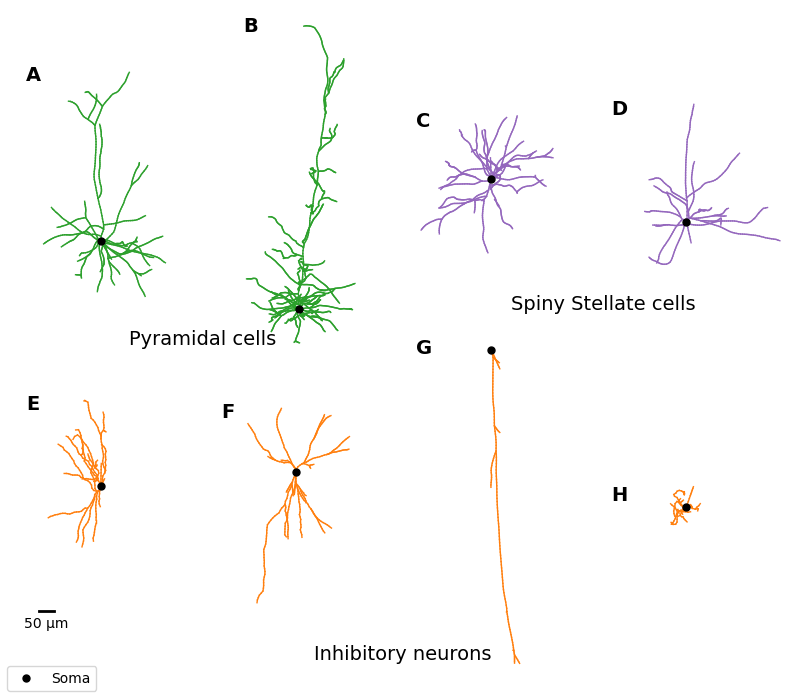

In [24]:
# Figure 5
plot_neuron_shape_examples(plot_file_paths)

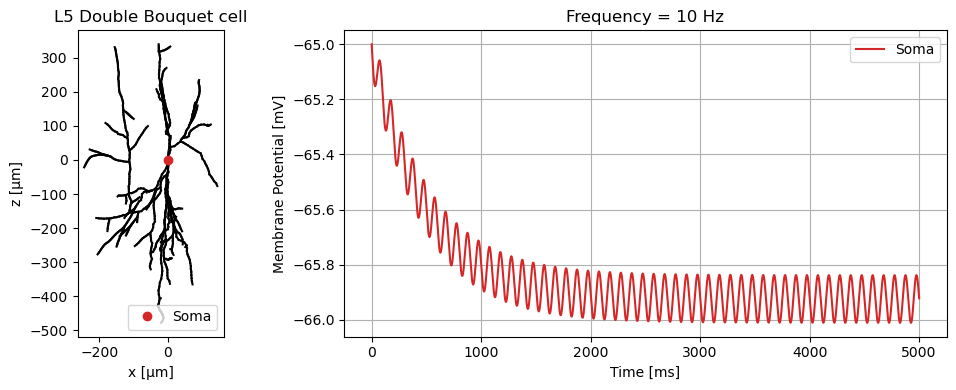

In [25]:
# Figure 9
plot_vmem_stabilization(plot_file_paths)

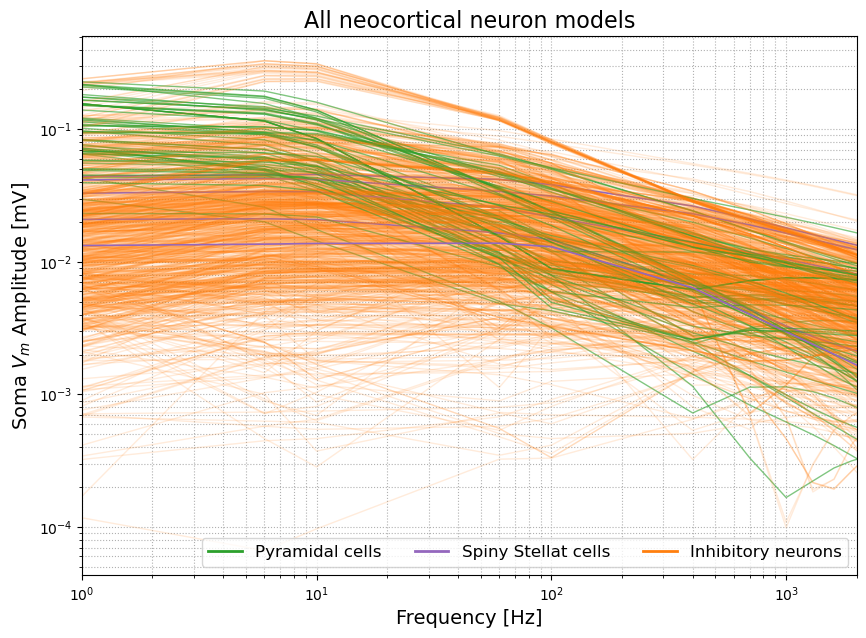

In [26]:
# Figure 14
plot_soma_amp_freq(amp_data)

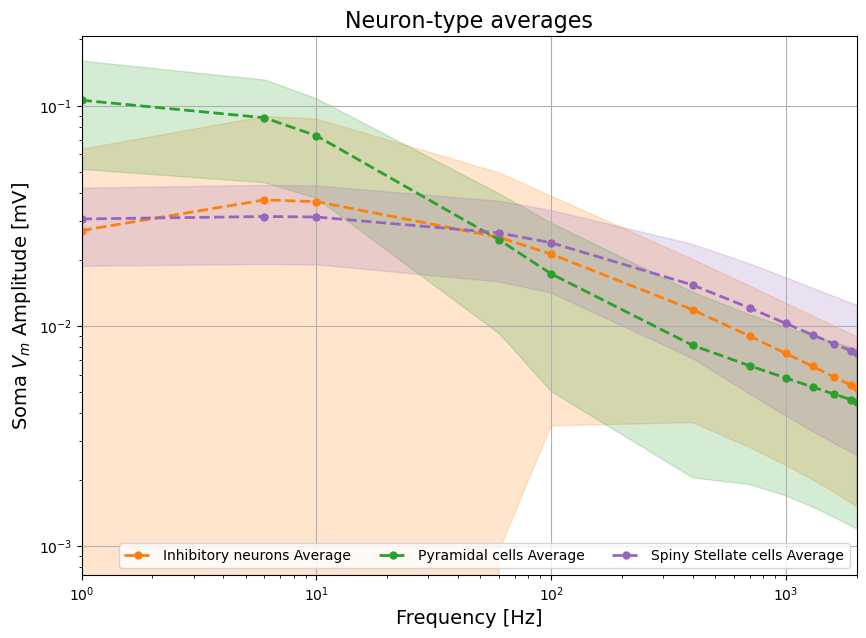

In [27]:
# Figure 15
calculate_avg_soma_amplitude(amp_data)
plot_soma_avg_and_std_celltypes(avg_amp_data_celltype)

### Mann-Whitney U Test 10 Hz $z$-oriented field

In [28]:
# Table 2
soma_amp_10Hz_inhb = []
soma_amp_10Hz_PC = []
soma_amp_10Hz_SS = []
for neuron, data in amp_data.items():
    freq_idx = data['freq'].index(10) 
    if 'PC' in neuron or 'SP' in neuron:
        soma_amp_10Hz_PC.append(data['soma_amp'][freq_idx])
    elif 'SS' in neuron: 
        soma_amp_10Hz_SS.append(data['soma_amp'][freq_idx])
    else:
        soma_amp_10Hz_inhb.append(data['soma_amp'][freq_idx])

# Mann-Whitney U Tests
mw_12_stat_10, mw_12_p_10 = mannwhitneyu(soma_amp_10Hz_PC, soma_amp_10Hz_inhb, alternative='greater')
mw_13_stat_10, mw_13_p_10 = mannwhitneyu(soma_amp_10Hz_PC, soma_amp_10Hz_SS, alternative='greater')
mw_23_stat_10, mw_23_p_10 = mannwhitneyu(soma_amp_10Hz_SS, soma_amp_10Hz_inhb, alternative='greater')

print(f"Mann-Whitney U Test 10 Hz (Data1 vs Data2): U={mw_12_stat_10}, p={mw_12_p_10}")
print(f"Mann-Whitney U Test 10 Hz (Data1 vs Data3): U={mw_13_stat_10}, p={mw_13_p_10}")
print(f"Mann-Whitney U Test 10 Hz (Data2 vs Data3): U={mw_23_stat_10}, p={mw_23_p_10}")

Mann-Whitney U Test 10 Hz (Data1 vs Data2): U=46425.0, p=6.325954287852004e-18
Mann-Whitney U Test 10 Hz (Data1 vs Data3): U=258.0, p=0.0009823801826956825
Mann-Whitney U Test 10 Hz (Data2 vs Data3): U=2951.0, p=0.18791586036208502


### Mann-Whitney U Test 1000 Hz $z$-oriented field

In [29]:
# Table 2
soma_amp_1000Hz_inhb = []
soma_amp_1000Hz_PC = []
soma_amp_1000Hz_SS = []
for neuron, data in amp_data.items():
    freq_idx = data['freq'].index(1000) 
    if 'PC' in neuron or 'SP' in neuron:
        soma_amp_1000Hz_PC.append(data['soma_amp'][freq_idx])
    elif 'SS' in neuron: 
        soma_amp_1000Hz_SS.append(data['soma_amp'][freq_idx])
    else:
        soma_amp_1000Hz_inhb.append(data['soma_amp'][freq_idx])

# Mann-Whitney U Tests
mw_12_stat, mw_12_p = mannwhitneyu(soma_amp_1000Hz_inhb, soma_amp_1000Hz_PC, alternative='greater')
mw_13_stat, mw_13_p = mannwhitneyu(soma_amp_1000Hz_SS, soma_amp_1000Hz_inhb, alternative='greater')
mw_23_stat, mw_23_p = mannwhitneyu(soma_amp_1000Hz_SS, soma_amp_1000Hz_PC, alternative='greater')

print(f"Mann-Whitney U Test 1000 Hz (Data1 vs Data2): U={mw_12_stat}, p={mw_12_p}")
print(f"Mann-Whitney U Test 1000 Hz (Data1 vs Data3): U={mw_13_stat}, p={mw_13_p}")
print(f"Mann-Whitney U Test 1000 Hz (Data2 vs Data3): U={mw_23_stat}, p={mw_23_p}")

Mann-Whitney U Test 1000 Hz (Data1 vs Data2): U=33217.0, p=0.006706730886683912
Mann-Whitney U Test 1000 Hz (Data1 vs Data3): U=2965.0, p=0.18190616656575398
Mann-Whitney U Test 1000 Hz (Data2 vs Data3): U=204.0, p=0.07024053873985306


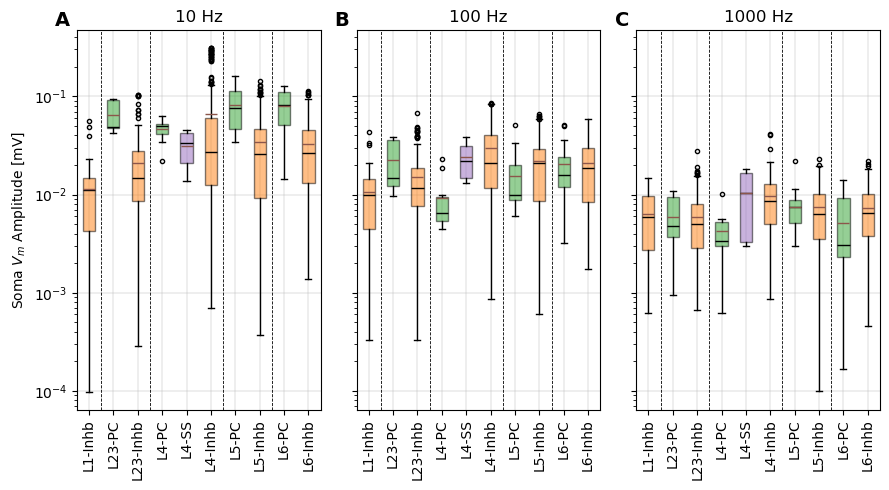

In [30]:
# Figure 16
plot_soma_amplitude_box(amp_data, target_freqs = [10, 100, 1000])

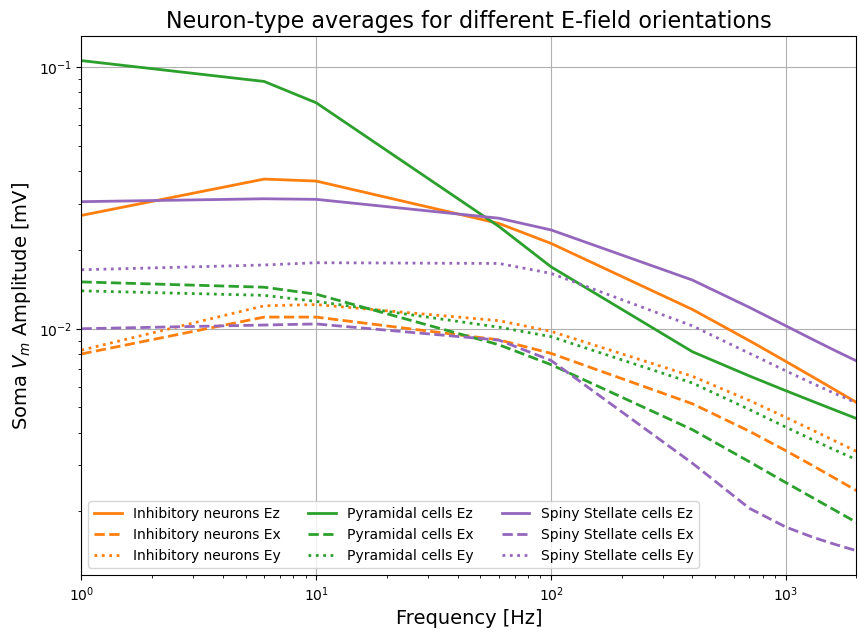

In [31]:
# Figure 17
calculate_avg_soma_amplitude(amp_data_Ex)
calculate_avg_soma_amplitude(amp_data_Ey)
plot_cell_type_average_different_Efields(avg_amp_data_celltype, avg_amp_data_celltype_Ex, avg_amp_data_celltype_Ey)

### Mann-Whitney U Test 1000 Hz $x$-oriented field

In [32]:
soma_amp_1000Hz_inhb_Ex = []
soma_amp_1000Hz_PC_Ex = []
soma_amp_1000Hz_SS_Ex = []
for neuron, data in amp_data_Ex.items():
    freq_idx = data['freq'].index(1000) 
    if 'PC' in neuron or 'SP' in neuron:
        soma_amp_1000Hz_PC_Ex.append(data['soma_amp'][freq_idx])
    elif 'SS' in neuron: 
        soma_amp_1000Hz_SS_Ex.append(data['soma_amp'][freq_idx])
    else:
        soma_amp_1000Hz_inhb_Ex.append(data['soma_amp'][freq_idx])

# Mann-Whitney U Tests
mw_12_stat_Ex, mw_12_p_Ex = mannwhitneyu(soma_amp_1000Hz_inhb_Ex, soma_amp_1000Hz_PC_Ex, alternative='greater')
mw_13_stat_Ex, mw_13_p_Ex = mannwhitneyu(soma_amp_1000Hz_SS_Ex, soma_amp_1000Hz_inhb_Ex, alternative='greater')
mw_23_stat_Ex, mw_23_p_Ex = mannwhitneyu(soma_amp_1000Hz_SS_Ex, soma_amp_1000Hz_PC_Ex, alternative='greater')

print(f"Mann-Whitney U Test 1000 Hz (Data1 vs Data2): U={mw_12_stat_Ex}, p={mw_12_p_Ex}")
print(f"Mann-Whitney U Test 1000 Hz (Data1 vs Data3): U={mw_13_stat_Ex}, p={mw_13_p_Ex}")
print(f"Mann-Whitney U Test 1000 Hz (Data2 vs Data3): U={mw_23_stat_Ex}, p={mw_23_p_Ex}")

Mann-Whitney U Test 1000 Hz (Data1 vs Data2): U=33844.0, p=0.002881675876766008
Mann-Whitney U Test 1000 Hz (Data1 vs Data3): U=1263.0, p=0.9663693171078118
Mann-Whitney U Test 1000 Hz (Data2 vs Data3): U=108.0, p=0.8244559883007839


### Mann-Whitney U Test 1000 Hz $y$-oriented field

In [33]:
soma_amp_1000Hz_inhb_Ey = []
soma_amp_1000Hz_PC_Ey = []
soma_amp_1000Hz_SS_Ey = []
for neuron, data in amp_data_Ey.items():
    freq_idx = data['freq'].index(1000) 
    if 'PC' in neuron or 'SP' in neuron:
        soma_amp_1000Hz_PC_Ey.append(data['soma_amp'][freq_idx])
    elif 'SS' in neuron: 
        soma_amp_1000Hz_SS_Ey.append(data['soma_amp'][freq_idx])
    else:
        soma_amp_1000Hz_inhb_Ey.append(data['soma_amp'][freq_idx])

# Mann-Whitney U Tests
mw_12_stat_Ey, mw_12_p_Ey = mannwhitneyu(soma_amp_1000Hz_inhb_Ey, soma_amp_1000Hz_PC_Ey, alternative='greater')
mw_13_stat_Ey, mw_13_p_Ey = mannwhitneyu(soma_amp_1000Hz_SS_Ey, soma_amp_1000Hz_inhb_Ey, alternative='greater')
mw_23_stat_Ey, mw_23_p_Ey = mannwhitneyu(soma_amp_1000Hz_SS_Ey, soma_amp_1000Hz_PC_Ey, alternative='greater')

print(f"Mann-Whitney U Test 1000 Hz (Data1 vs Data2): U={mw_12_stat_Ey}, p={mw_12_p_Ey}")
print(f"Mann-Whitney U Test 1000 Hz (Data1 vs Data3): U={mw_13_stat_Ey}, p={mw_13_p_Ey}")
print(f"Mann-Whitney U Test 1000 Hz (Data2 vs Data3): U={mw_23_stat_Ey}, p={mw_23_p_Ey}")

Mann-Whitney U Test 1000 Hz (Data1 vs Data2): U=29923.0, p=0.1691017266243096
Mann-Whitney U Test 1000 Hz (Data1 vs Data3): U=3667.0, p=0.020802534496573214
Mann-Whitney U Test 1000 Hz (Data2 vs Data3): U=237.0, p=0.00824004278368842


In [34]:
properties = ['closest_z_endpoint', 
                'distant_z_endpoint', 
                'upper_z_endpoint', 
                'bottom_z_endpoint', 
                'total_len', 
                'symmetry_factor', 
                'number_of_soma_dendrites', 
                'total_diam_soma_dendrites', 
                'soma_diam']

prop_names = {'closest_z_endpoint': 'Closest z endpoint', 
                'distant_z_endpoint': 'Distant z endpoint', 
                'upper_z_endpoint': 'Upper z endpoint', 
                'bottom_z_endpoint': 'Lower z endpoint', 
                'total_len': 'Total z Length', 
                'symmetry_factor': 'Symmetry-Factor (z-direction)', 
                'number_of_soma_dendrites': 'Number of dendrites\nconnected to soma', 
                'total_diam_soma_dendrites': 'Total diameter of dendrites\nconnected to soma', 
                'avg_diam_soma_dendrites': 'Average diameter of dendrites\nconnected to soma', 
                'soma_diam': 'Soma diameter',
                'diameter_factor': 'Soma diameter/Total denrite diameter\nconnected to soma',
                'dendrite_diam_length_factor': 'Total length/Total denrite diameter\nconnected to soma'}

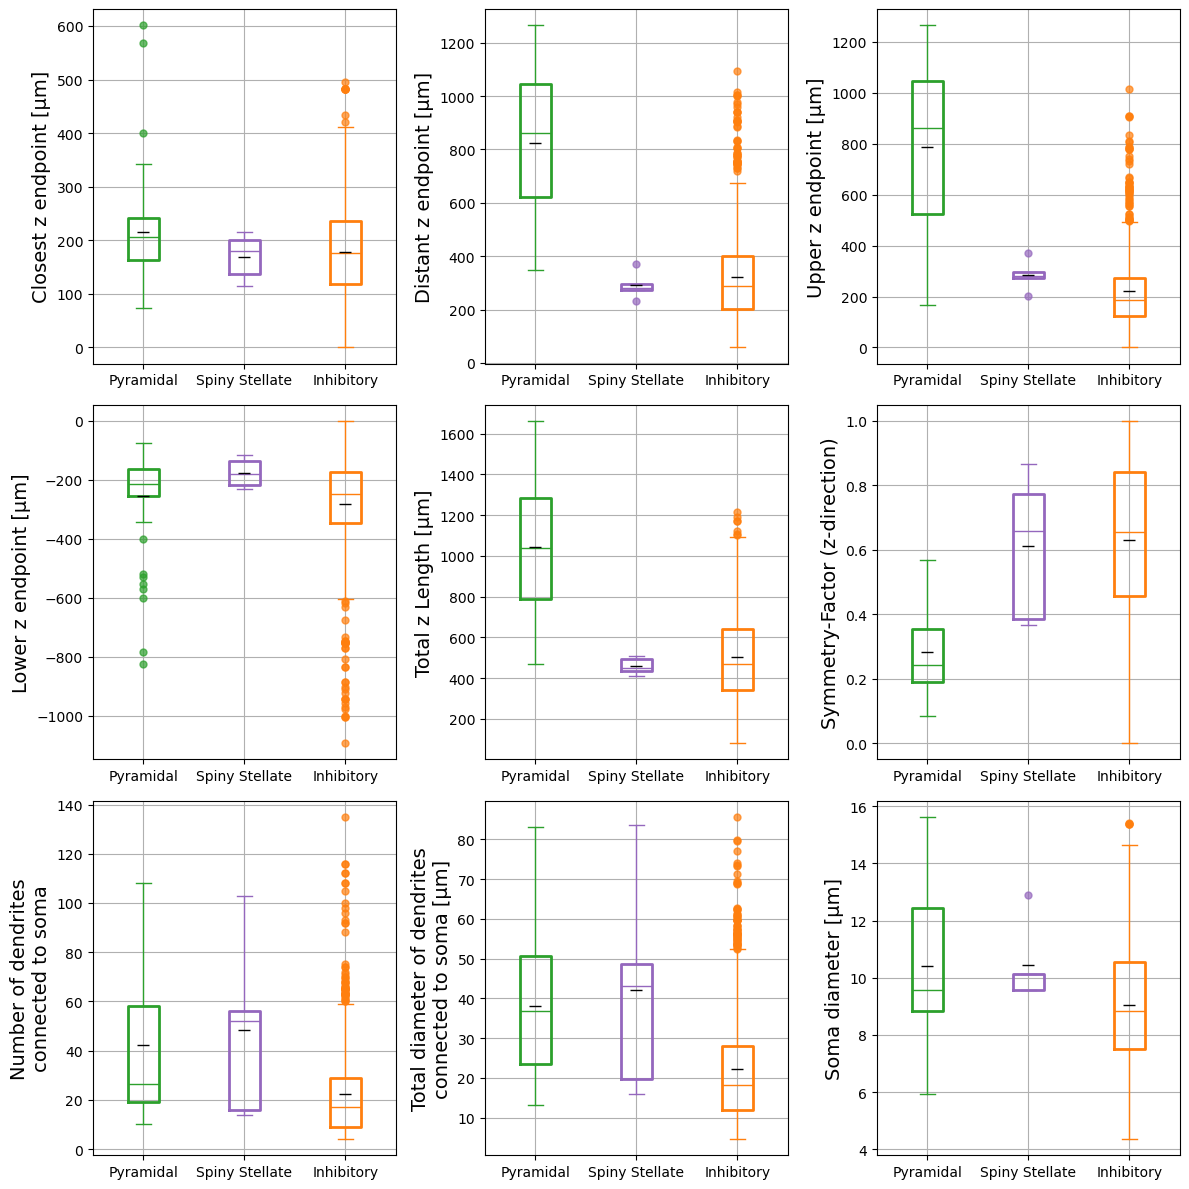

In [35]:
# Figure 18
box_plot_all_properties(amp_data, properties, prop_names)

In [36]:
selected_properties = ['total_len', 'symmetry_factor', 'total_diam_soma_dendrites', 'soma_diam']
feature_importance_10 = analyze_feature_importance(amp_data,selected_properties, frequency = 10)

R^2 value = 0.5510946026442546
Feature importance values at 10 Hz:
Soma diam                                   -0.005601
Symmetry-\nfactor\nz-direction              -0.024882
Total diam\ndendrites\nconnected\nto soma   -0.006927
Total z\nlength                              0.019058
dtype: float64


In [37]:
feature_importance_1000 = analyze_feature_importance(amp_data, selected_properties, frequency = 1000)

R^2 value = 0.11215682178882946
Feature importance values at 1000 Hz:
Soma diam                                   -0.000581
Symmetry-\nfactor\nz-direction              -0.001564
Total diam\ndendrites\nconnected\nto soma   -0.000087
Total z\nlength                              0.000013
dtype: float64


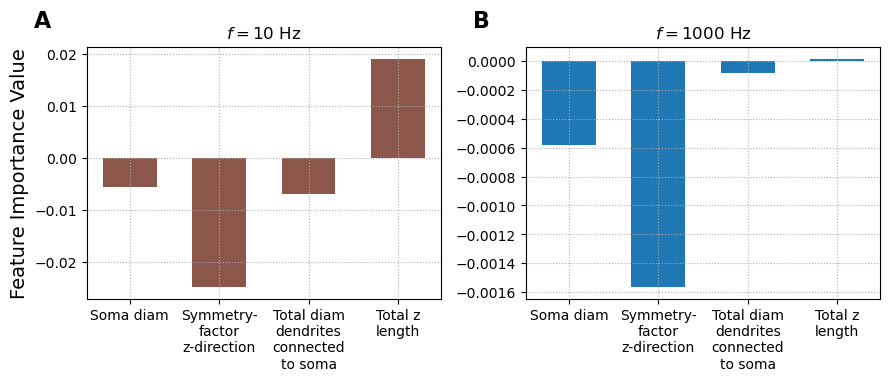

In [38]:
# Figure 19
plot_feature_importance(feature_importance_10, feature_importance_1000)

# Appendix figures

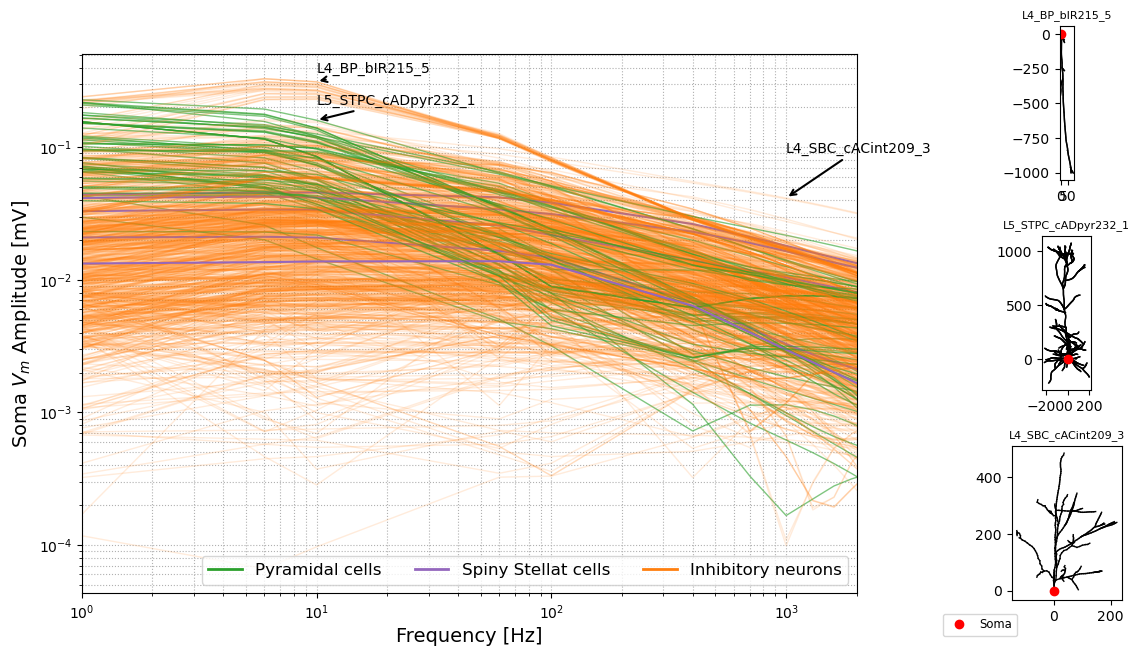

In [39]:
# Figure C.4
sort_neurons(amp_data)
plot_soma_amp_freq_with_arrow(amp_data,plot_file_paths, sorted_all_neurons_highest_soma_amp_10Hz, sorted_pc_cells_highest_soma_amp_10Hz, sorted_all_neurons_highest_soma_amp_1000Hz)

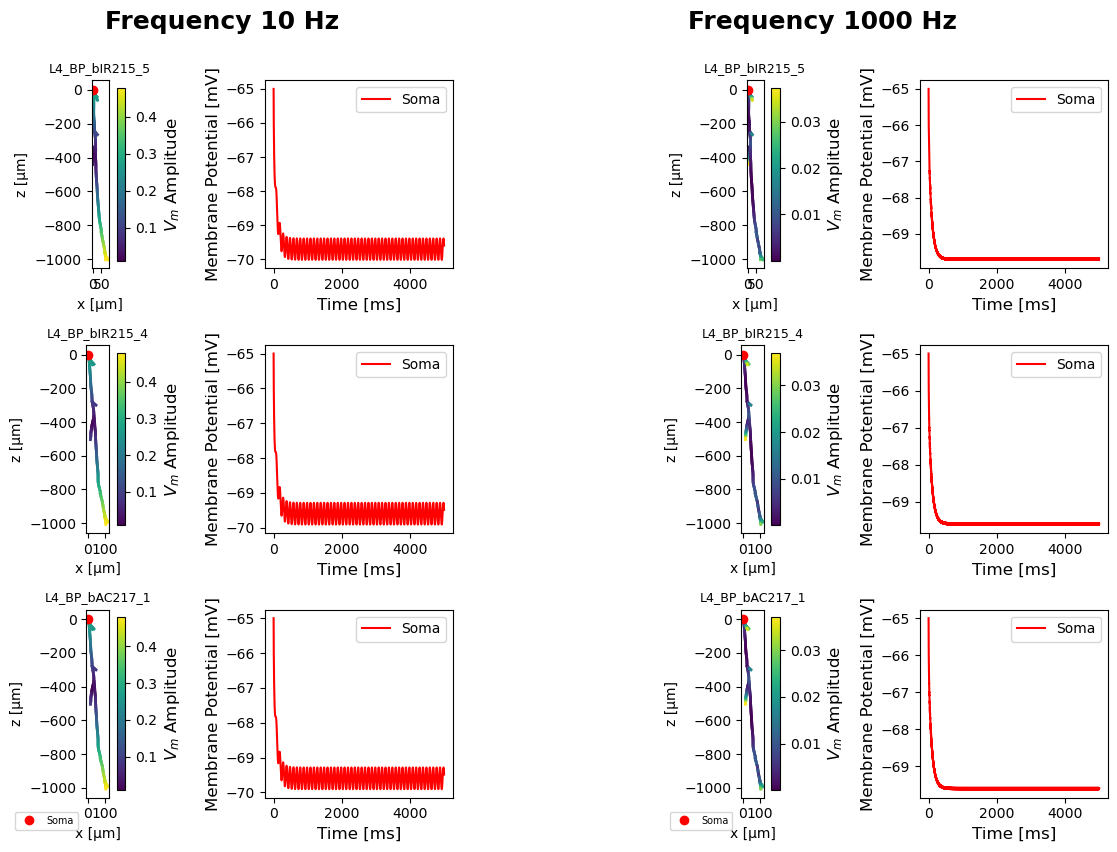

In [40]:
# Figure C.5
plot_cell_shape_and_vmem_from_npy(plot_file_paths, selected_cells=sorted_all_neurons_highest_soma_amp_10Hz[0:3], selected_frequencies = [10,1000]) 

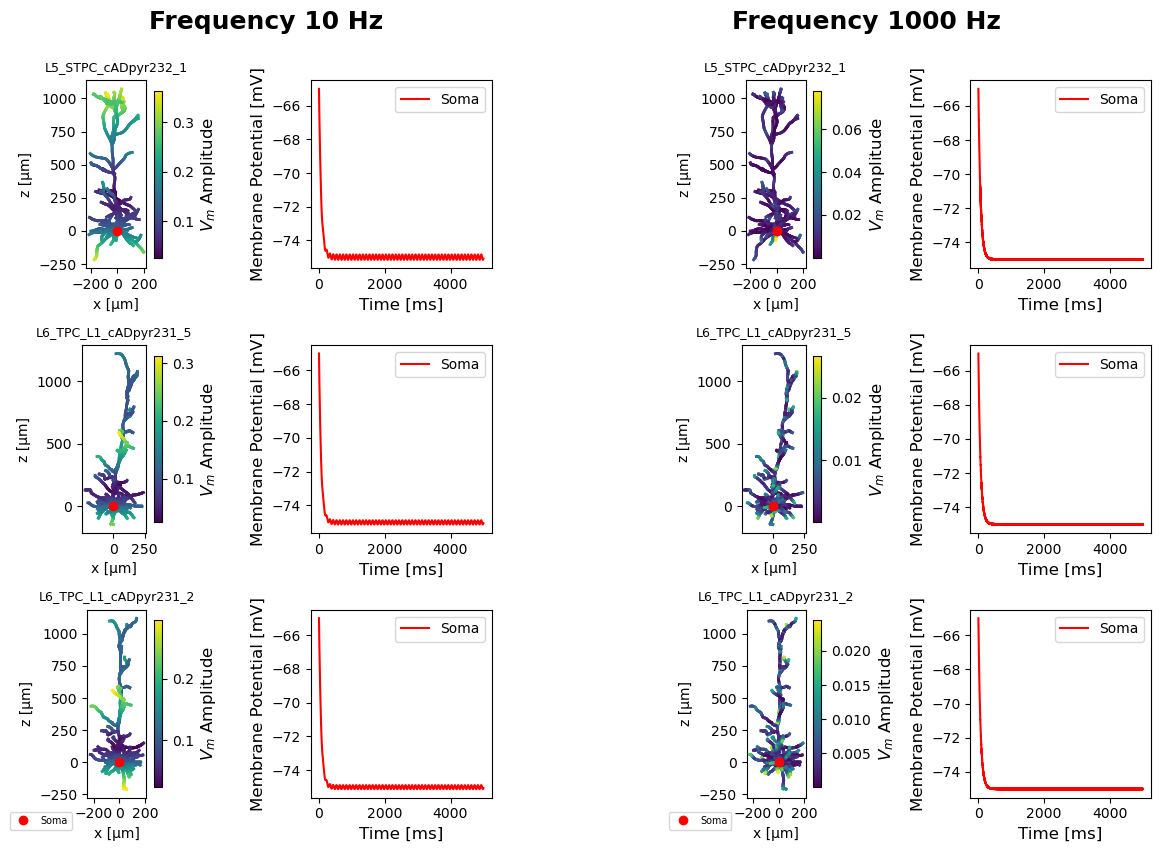

In [41]:
# Figure C.6
plot_cell_shape_and_vmem_from_npy(plot_file_paths, selected_cells=sorted_pc_cells_highest_soma_amp_1000Hz[0:3], selected_frequencies = [10,1000])

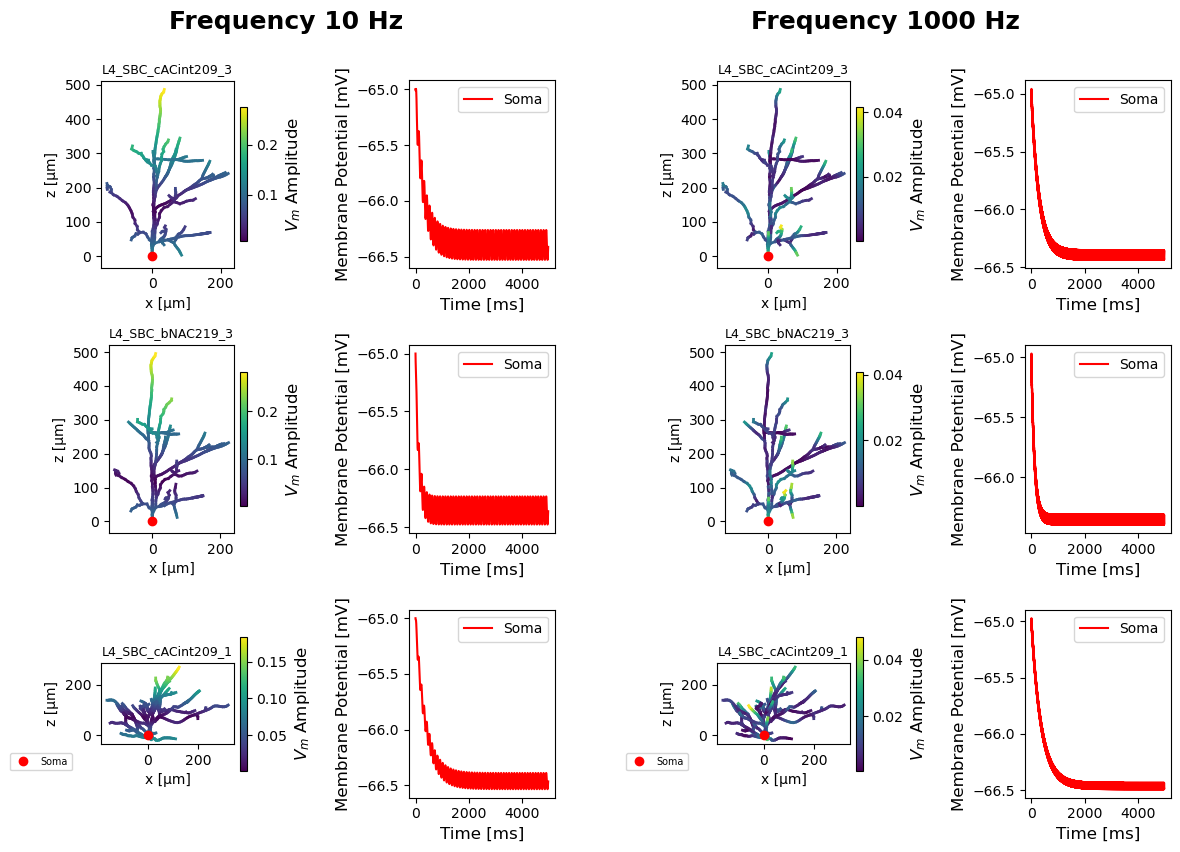

In [42]:
# Figure C.7
plot_cell_shape_and_vmem_from_npy(plot_file_paths, selected_cells=sorted_all_neurons_highest_soma_amp_1000Hz[0:3], selected_frequencies = [10,1000])

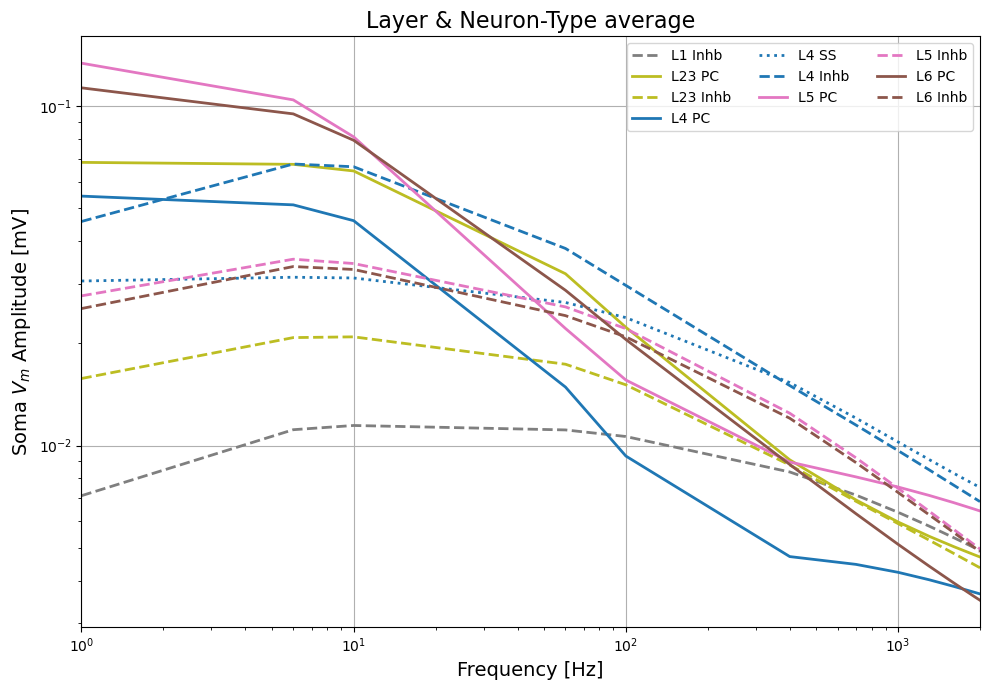

In [43]:
# Figure C.8
calculate_avg_soma_amplitude_layer(amp_data)
plot_soma_avg_layer(avg_amp_data_layer)

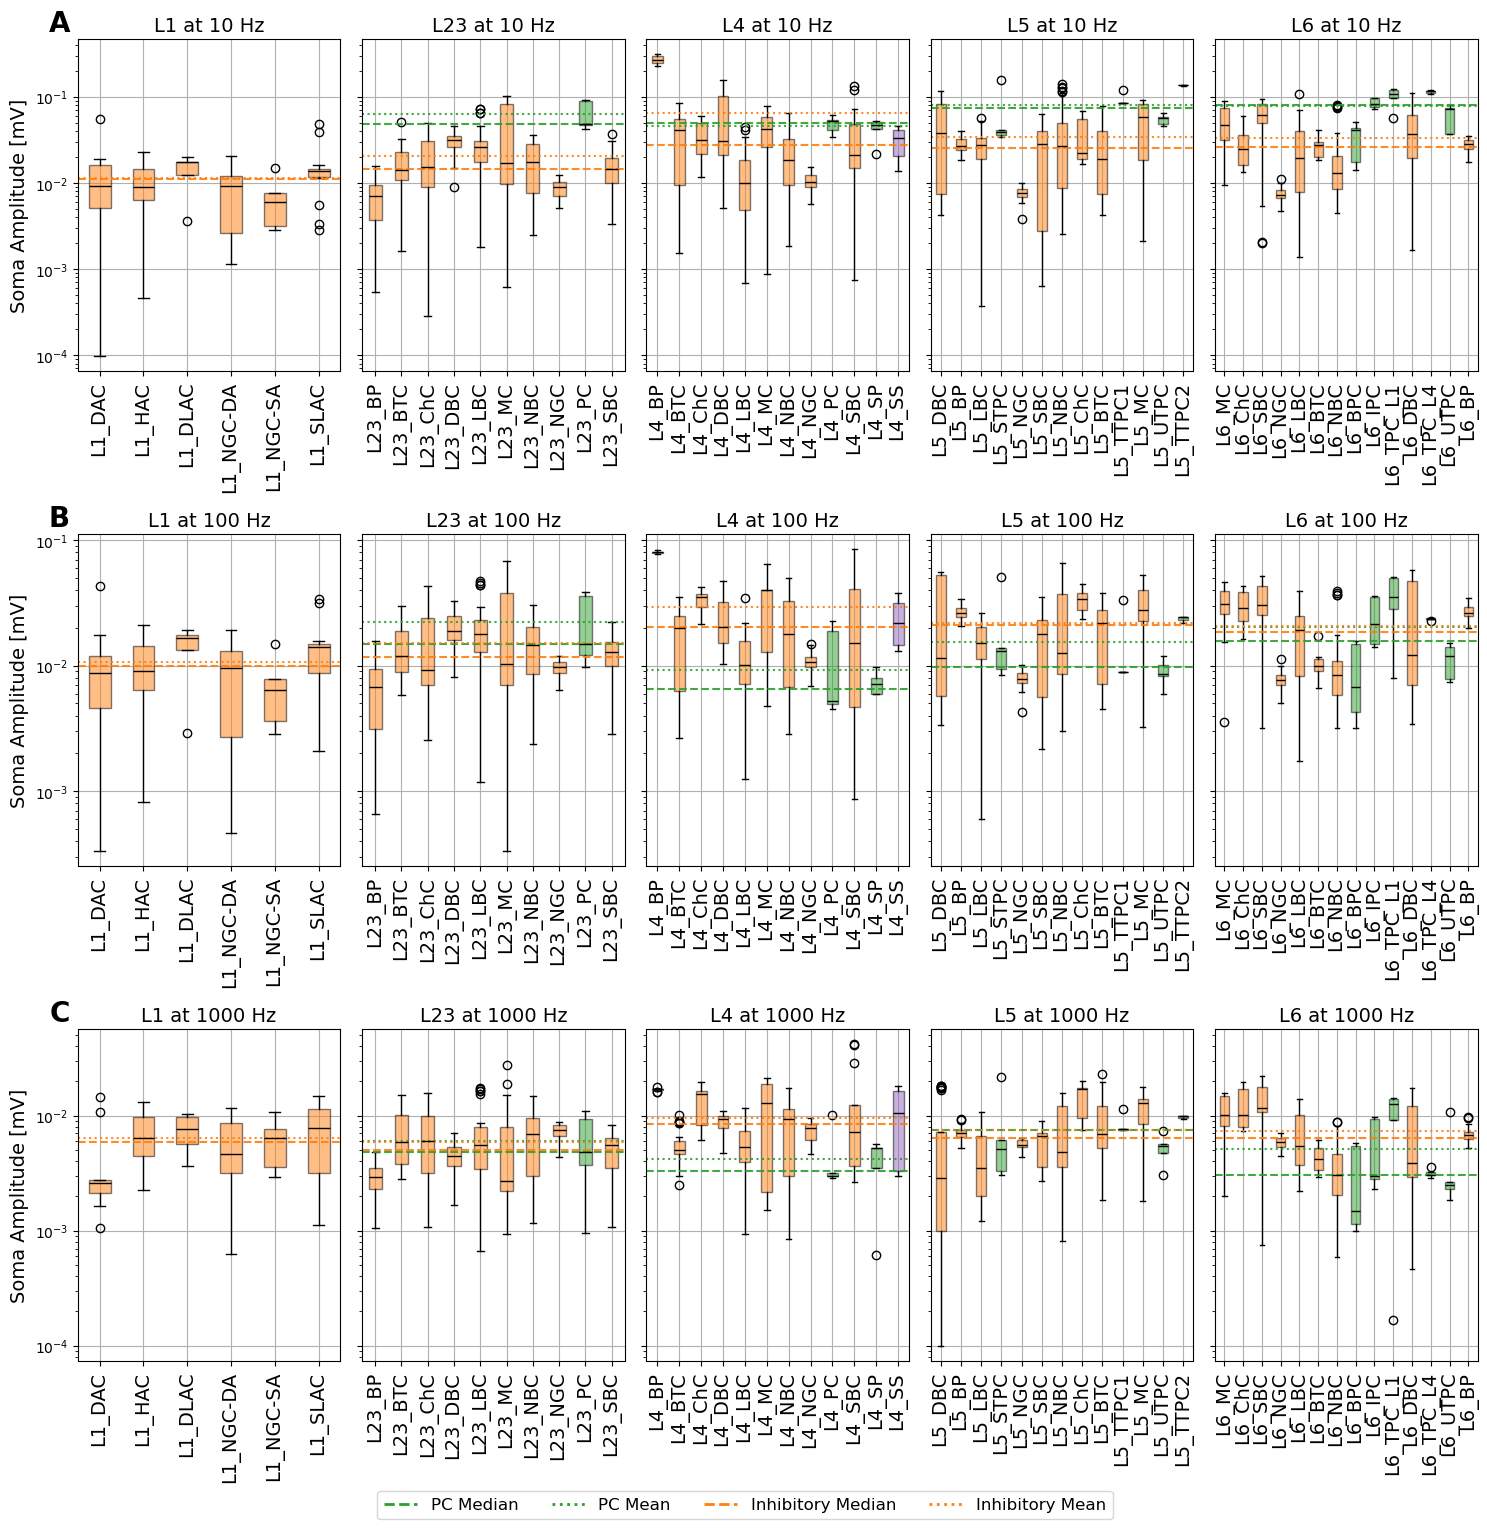

In [44]:
# Figure C.9
plot_soma_amplitude_box_layers_more_categories_separated(amp_data, target_freqs=[10, 100, 1000])

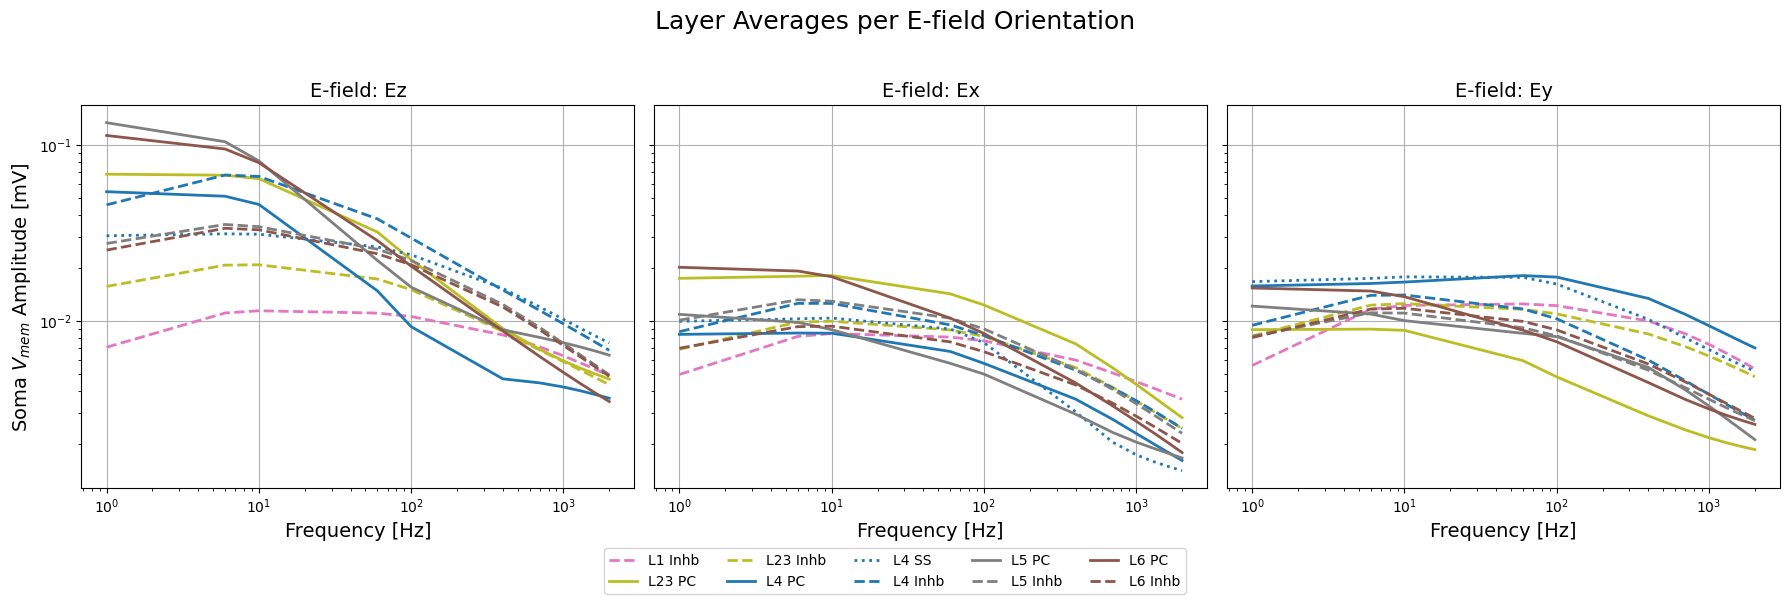

In [45]:
# Figure C.10
calculate_avg_soma_amplitude_layer(amp_data_Ex)
calculate_avg_soma_amplitude_layer(amp_data_Ey)
plot_layer_average_different_Efields(avg_amp_data_layer, avg_amp_data_layer_Ex, avg_amp_data_layer_Ey)

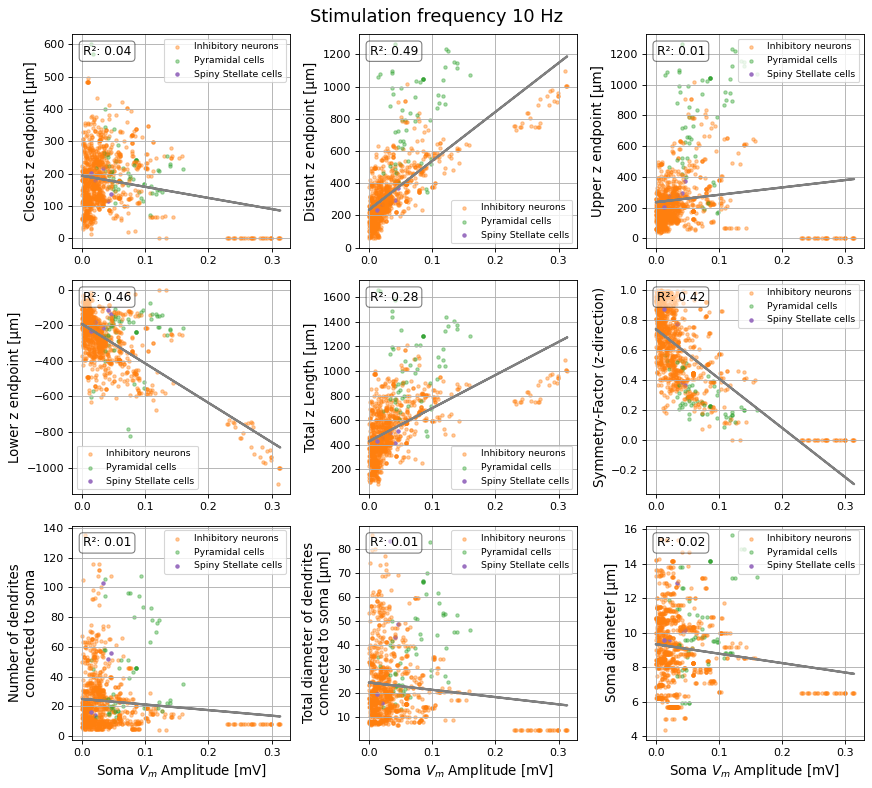

In [46]:
# Figure C.11
scatter_plot_all_properties_with_reg(amp_data, properties, prop_names, at_freq=10)

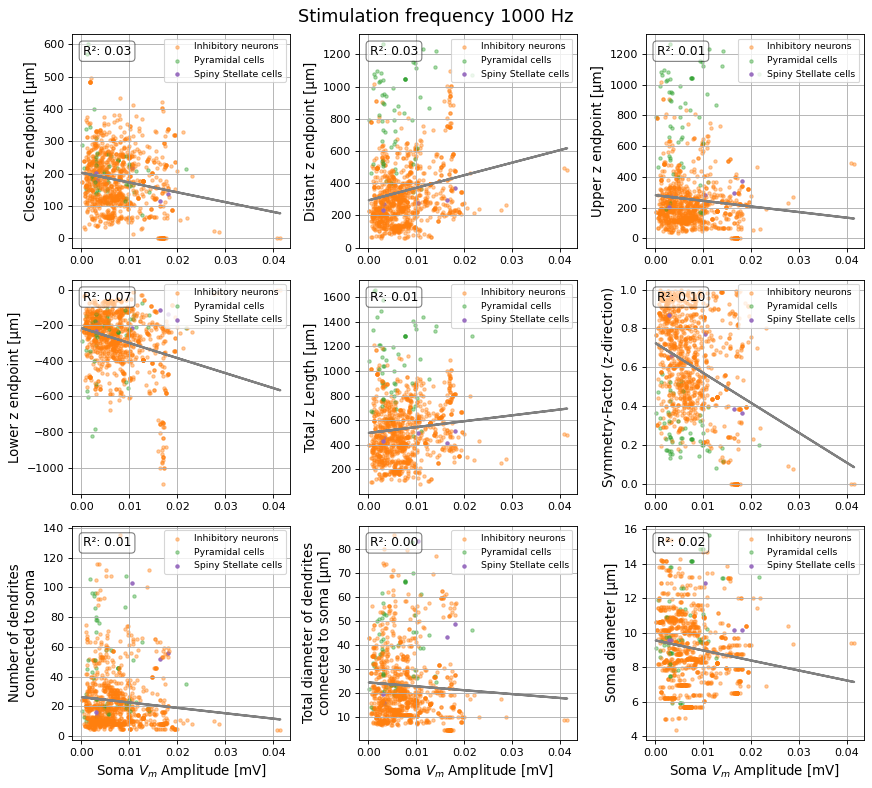

In [47]:
# Figure C.12
scatter_plot_all_properties_with_reg(amp_data, properties, prop_names, at_freq=1000)

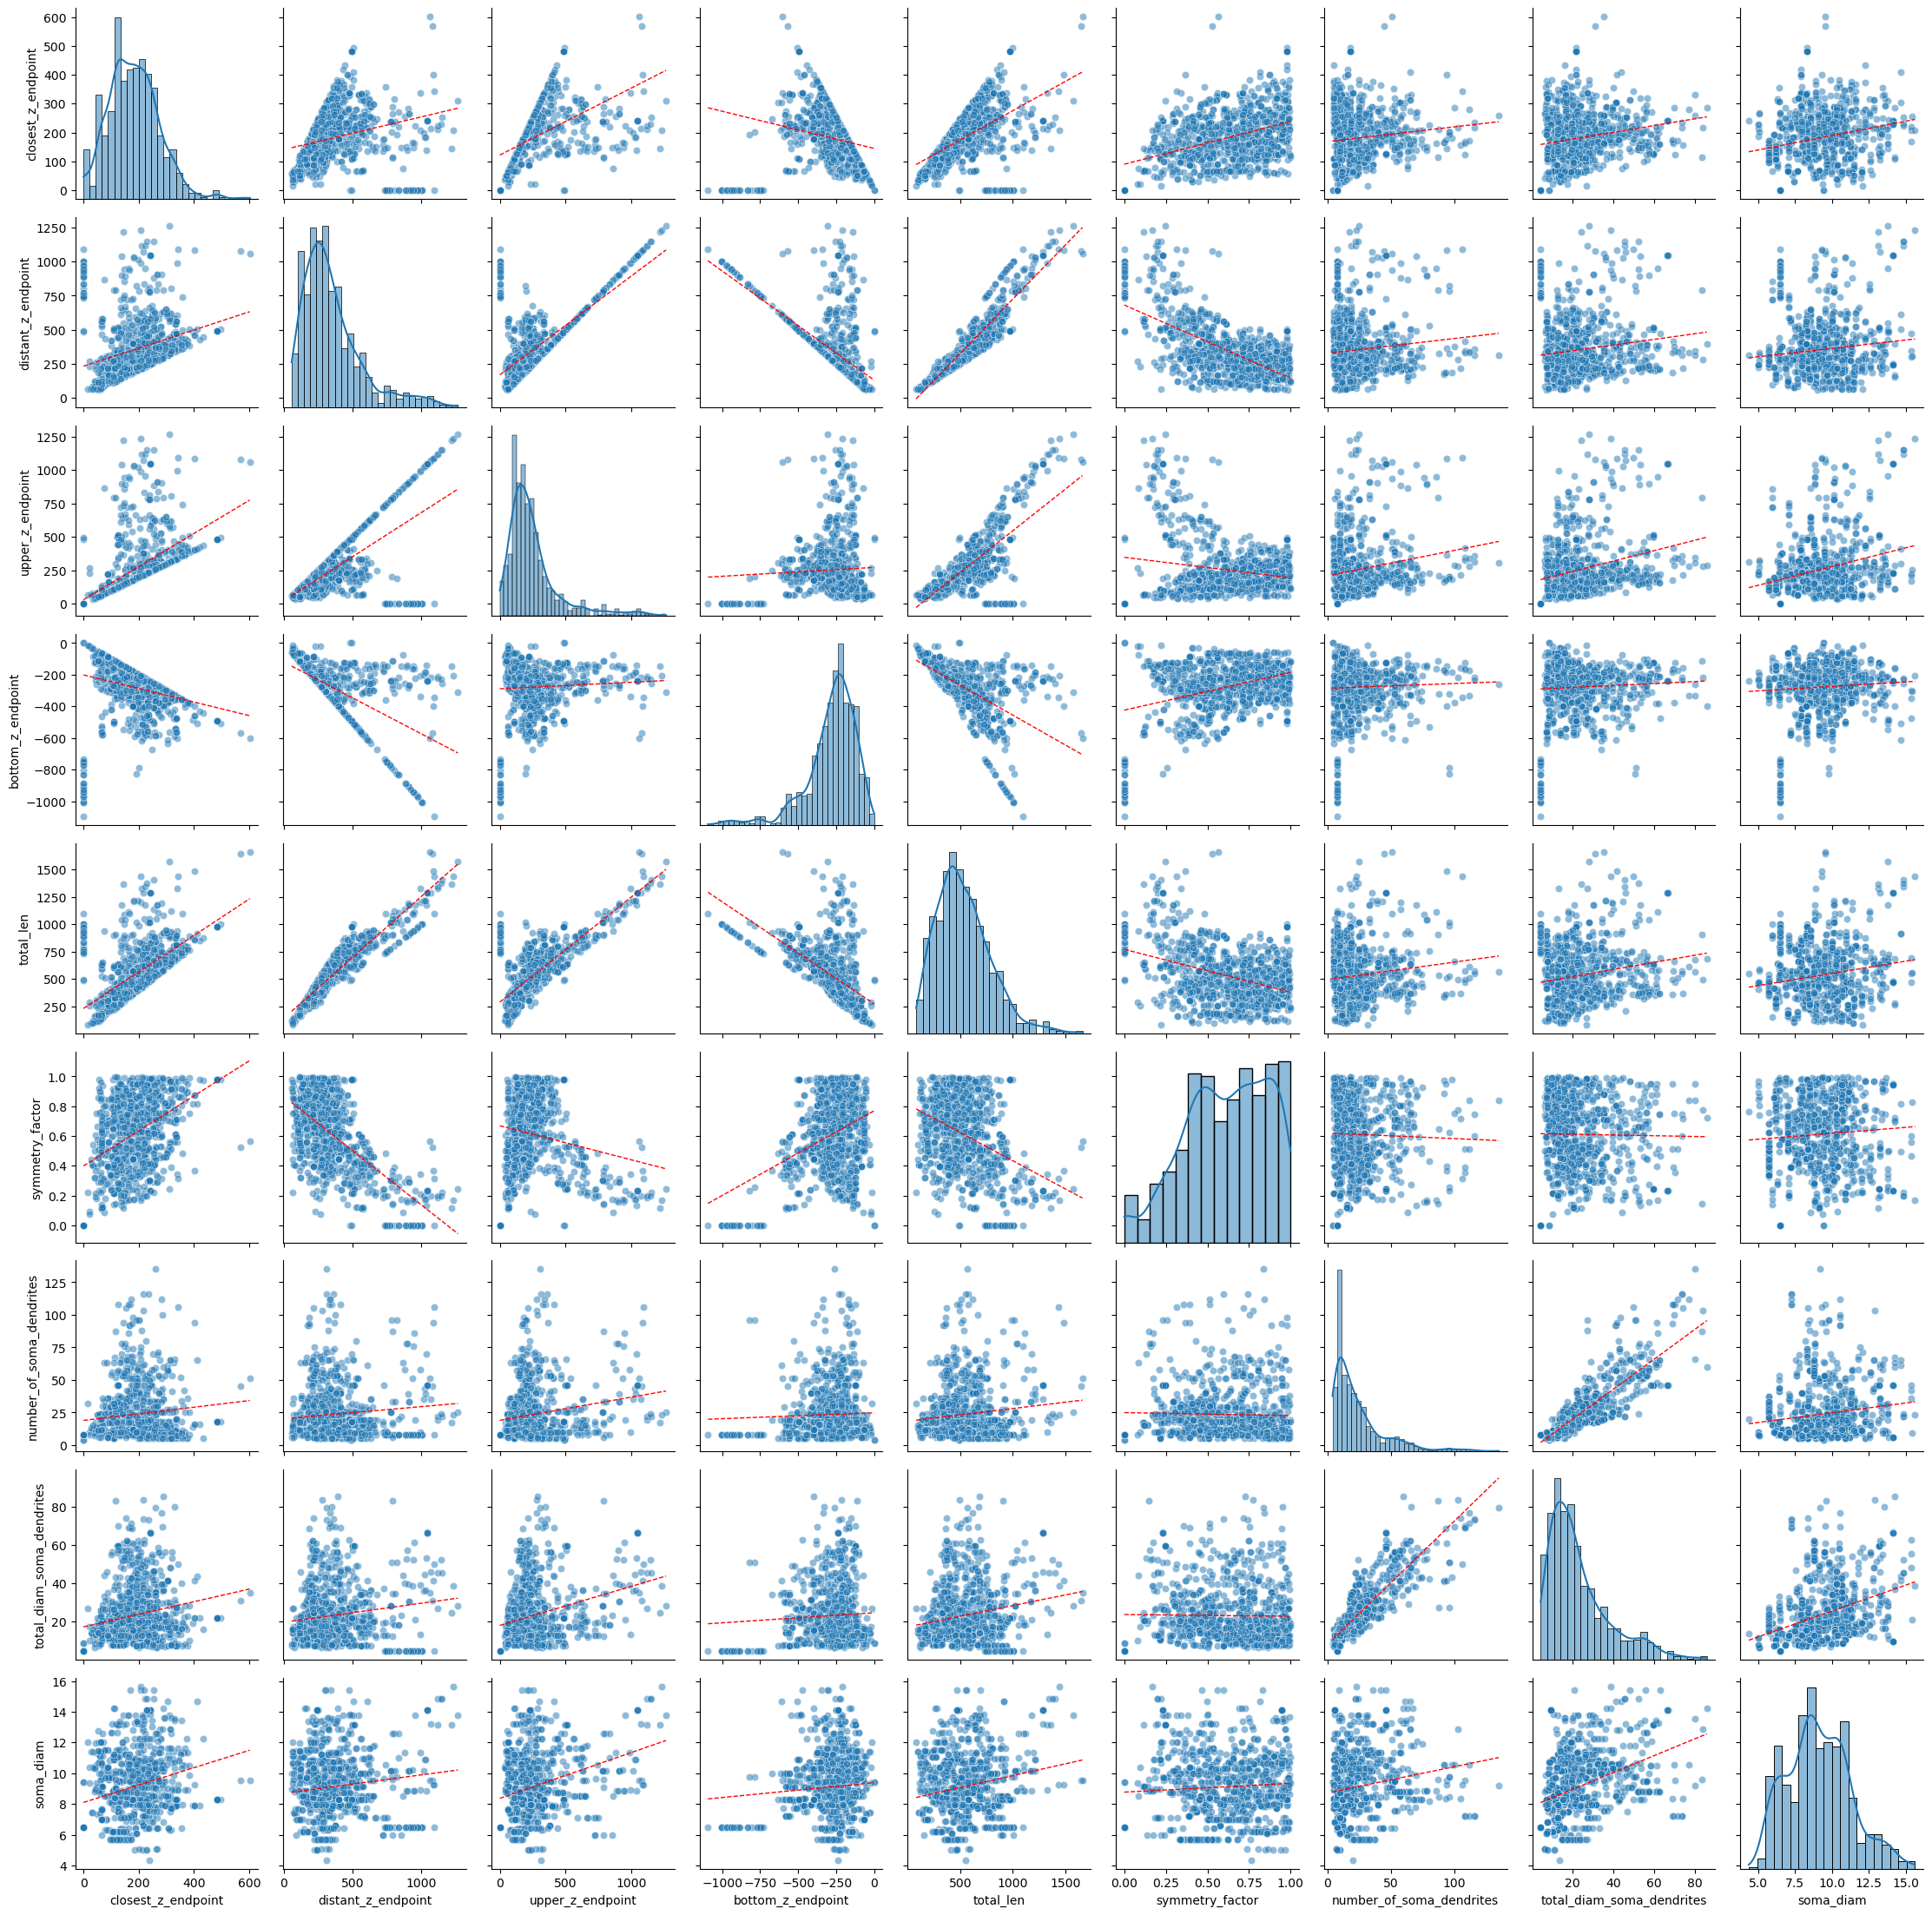

In [48]:
# Figure C.13
scatter_matrix_with_regression(amp_data, properties)

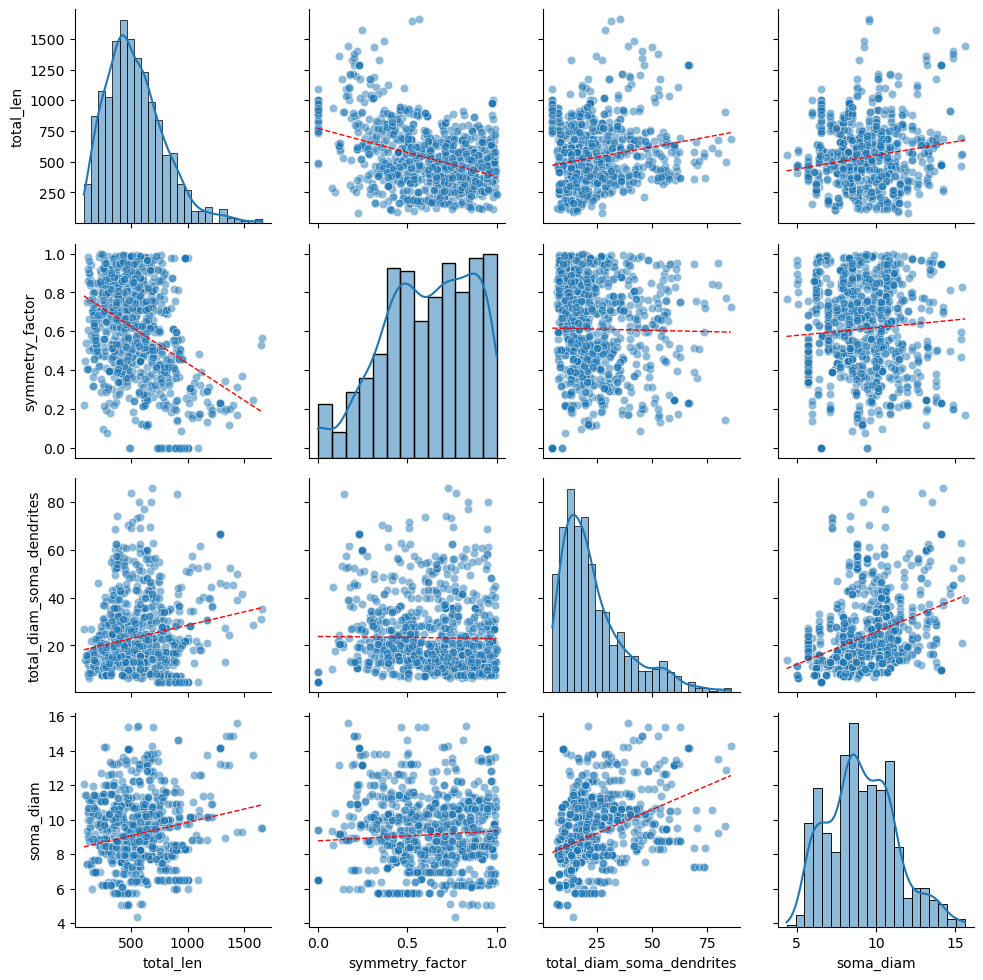

In [49]:
# Figure C.14
selected_properties = ['total_len', 'symmetry_factor', 'total_diam_soma_dendrites', 'soma_diam']
scatter_matrix_with_regression(amp_data, selected_properties)